# Instruções
#### objetivo geral: criar uma rede neural para classificação de imagens do dataset fashion mnist e exploração de todas as características da rede neural, uma por vez.
O melhor resultado de cada questão/etapa é utilizado nas próximas

### QUESTÃO 01: exploração inicial
- Dataset fashion mnist
- função de ativação
- 5 testes com inicialização aleatória: diferenças de convergencia, estabilidade e desempenho
- dataset de treino
- métricas: medida de desempenho(accuracy), função de perda (entropia cruzada/loss), curva de convergência
- otimizador: Adam
- arquitetura: quantas camadas e neurônios por camada
- funcoes de ativação: ReLU, Sigmoid ou Tanh
- quantas épocas
- taxa de aprendizado
- indícios de under/overfitting

### QUESTÃO 02: exploração de hiperparâmetros
- taxa de aprendizado x termo momento x velocidade de convergência
- Grid search para encontrar a melhor combinação: erro de treinamento x taxa de aprendizado x momento
- taxa de aprendizado menor e momento intermediário
- dataset de treino e (opcionalmente) dataset de validação
- métricas: função de perda, velocidade de convergência, curva de convergência e (opcional) estabilidade
- critério de parada
- combinação com melhor equilíbrio entre velocidadee estabilidade
- tendências observadas(ex: maior taxa de aprendizado leva a maior velocidade, mas menor estabilidade)

### QUESTÃO 03: topologia de rede neural
- dataset de treino e (opcionalmente) dataset de validação
- impacto do número de camadas ocultas e neurônios por camada e teste de variação desses números
- métricas: função de perda, curva de convergência(under e overfitting), tempo de treinamento, generalização(medida F), precisão, revocação
- gráfico de perda mostrando diferença entre topologias

### QUESTÃO 04: qualidade dos dados
- influência do número e qualidade dos dados, ruído, etc sobre a capacidade de generalização
- dividir o dataset em subsets de acordo com o rótulo -> manter proporcionalidade
- faixas do dataset: 10%, 30%, 50%, 70%, 100%
- métrica: função de perda, acurácia,
- identificar saturação no aprendizado
- curvas de generalização: tamanho do conjunto X desempenho
- tempo de treinamento e custo computacional
- Estratégia de amostragem(estratificada, aleatória ou outra)

### QUESTÃO 05:
- escolher 4 melhores modelos e usar modelo de testes neles
- treinamento como referência comparativa
- ajustes de otimização
- métricas: perda(entropia cruzada categórica), acurácia, curva de validação(treinamento x teste), F1 score, precisão, revocação
- escolha da configuração final do modelo

### QUESTÃO 06: validação cruzada k-fold
divisão do dataset em k-subconjuntos e teste em todos eles
- métricas: média de todas as partições de perda: acurácia e F1.
- para cada partição: curvas de validação e variância(dispersão) dos resultados
- justificativa do tamanho de k
- identificação de flutuações
---

In [4]:
import numpy as np
import matplotlib.pyplot as plt
#from tensorflow import kerasimpor
from tensorflow import keras
from sklearn.model_selection import train_test_split
import secrets

# Divisão do dataset

In [5]:
#dataset já dividido em treino e teste
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
#split de treino entre 80% treino e 20% validação
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42, stratify=y_train) #20% do treino vira validação. stratify=Y mantém a proporção das classes
# Normalização (0-1) para visualização e futura modelagem
x_train = x_train.astype("float32")/255.0
x_test = x_test.astype("float32")/255.0
x_val = x_val.astype("float32")/255.0
"""
converte inteiro discreto de 0 a 255 para contínuo float de 0.0 a 1.0
redes neurais funcionam melhor com entradas contínuas e escala pequena e próxima
float representa melhor valores intermediários entre 2 as cores possíveis (preto e branco)
y é inteiro de 0 a 9, sendo o número sua classe, não precisa de normalização
"""

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


'\nconverte inteiro discreto de 0 a 255 para contínuo float de 0.0 a 1.0\nredes neurais funcionam melhor com entradas contínuas e escala pequena e próxima\nfloat representa melhor valores intermediários entre 2 as cores possíveis (preto e branco)\ny é inteiro de 0 a 9, sendo o número sua classe, não precisa de normalização\n'

# vizualização do dataset Fashion-MNIST

Treino: (48000, 28, 28), Validação: (12000, 28, 28), Teste: (10000, 28, 28)
Exemplo de rótulos (0-9): ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


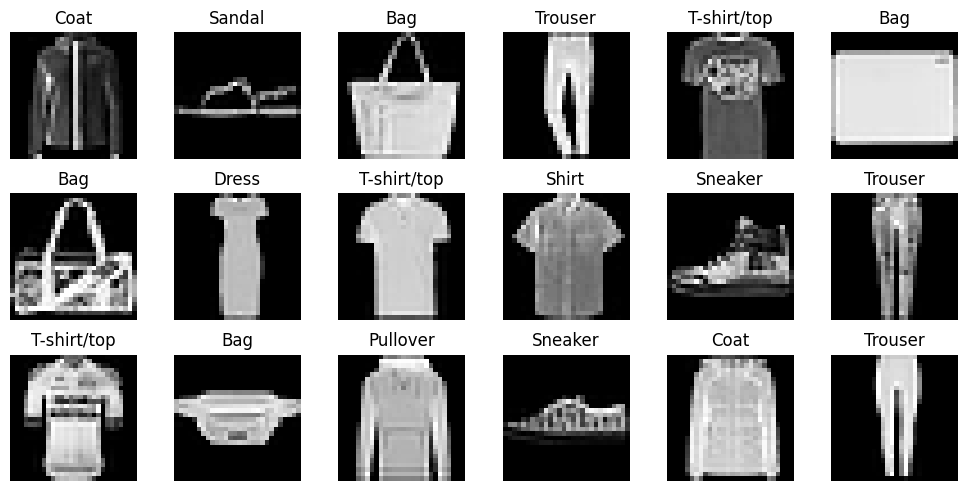

In [6]:
labels = [
    "T-shirt/top","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankle boot"
]

print(f"Treino: {x_train.shape}, Validação: {x_val.shape}, Teste: {x_test.shape}")
print("Exemplo de rótulos (0-9):", labels)

# Grid de amostras aleatórias do conjunto de treino
fig, axes = plt.subplots(3, 6, figsize=(10, 5))
for i, ax in enumerate(axes.ravel()):
    idx = np.random.randint(0, len(x_train))
    ax.imshow(x_train[idx], cmap="gray")
    ax.set_title(labels[y_train[idx]])
    ax.axis("off")
plt.tight_layout()
plt.show()

# Questão 01: Rede neural simples

### Modelo

In [7]:
"""
configuração padrão:
    camada de entrada com 784 neurônios(cada pixel da imagem 28x28)
    2 camadas ocultas (64 e 32 neurônios)
    camada de saída com 10 neurônios (10 classes)
"""

def build_model(learning_rate=1e-3, beta1=0.9, activation_hidden = 'relu', activation_output = 'softmax', num_hidden_layers=2, neurons_per_layer=[64, 32]):

    layers = [
        keras.layers.InputLayer(shape=(28, 28)),  # imagens 28x28 pixels, cada pixel é um neurônio de entrada
        keras.layers.Flatten()  # transforma matriz 2D 28x28 em vetor 1D com 784 elementos
    ]
    # adiciona dinamicamente as camadas ocultas conforme num_hidden_layers
    for i in range(num_hidden_layers):
        layers.append(keras.layers.Dense(neurons_per_layer[i], activation_hidden))  # ReLU como função de ativação não linear

    # camada de saída
    layers.append(keras.layers.Dense(10, activation_output))  # 10 saídas (classes) possíveis

    # modelo sequencial -> "clássico" com uma camada após a outra
    model = keras.Sequential(layers)

    optimizer = keras.optimizers.Adam(learning_rate, beta1)
    model.compile(
        optimizer = optimizer,  # aprendizado adaptativo
        loss='sparse_categorical_crossentropy',  # ideal para classificação multiclasse com rótulos inteiros
        metrics=['accuracy']  # medida de desempenho simples
    )
    return model


### gerador de seeds

In [8]:
PRIME_STEP = 2654435761  # grande e usado em hashing
MASK32 = 0xFFFFFFFF
base = secrets.randbits(32)

# ===== Método para "espaçar" mais as seeds =====
# Ideia: usar uma base aleatória de 32 bits e aplicar um incremento grande e primo
# (ex: 2654435761 = constante de Knuth) gerando progressão pseudo-dispersada em 32 bits.
# Depois aplicamos uma mistura (hash simples) para minimizar correlação linear.
def spaced_seeds(n, base_seed, step):
    seeds = []
    for i in range(n):
        raw = (base_seed + i * step) & MASK32
        # Mistura extra: multiplicação + xor + shift (barato, evita sequência muito próxima)
        mixed = (raw * 0x9E3779B1) & MASK32
        mixed ^= (mixed >> 16)
        seeds.append(mixed)
    return seeds

seeds = spaced_seeds(5, base, PRIME_STEP)

### treinamento

In [9]:
histories = []
final_metrics = []
log_lines = []

for i, seed in enumerate(seeds, start=1):
    keras.utils.set_random_seed(seed)
    model = build_model()
    h = model.fit(
        x_train, y_train,
        epochs=5,
        batch_size=128,
        verbose=0
    )
    histories.append(h)
    final_metrics.append({
        'run': i,
        'seed': seed,
        'final_train_loss': h.history['loss'][-1],
        'final_train_acc': h.history['accuracy'][-1]
    })
    log_lines.append(
        f"=== Treinamento {i}/5 (seed={seed}) ===\n"
        f"Train - Loss: {h.history['loss'][-1]:.4f}, accuracy: {h.history['accuracy'][-1]:.4f}"
    )

print("\n".join(log_lines))


=== Treinamento 1/5 (seed=702235665) ===
Train - Loss: 0.3370, accuracy: 0.8786
=== Treinamento 2/5 (seed=700584937) ===
Train - Loss: 0.3484, accuracy: 0.8753
=== Treinamento 3/5 (seed=698953509) ===
Train - Loss: 0.3384, accuracy: 0.8775
=== Treinamento 4/5 (seed=697301858) ===
Train - Loss: 0.3445, accuracy: 0.8767
=== Treinamento 5/5 (seed=695645752) ===
Train - Loss: 0.3368, accuracy: 0.8780


### visualização

estrutura das histories: {'accuracy': [0.7756875157356262, 0.8474166393280029, 0.8633750081062317, 0.8717708587646484, 0.8779791593551636], 'loss': [0.6403027176856995, 0.43072614073753357, 0.3836936056613922, 0.3560768663883209, 0.33678022027015686]}
é possível adicionar mais informações no dicionário history, como f1, recall, precision, etc.


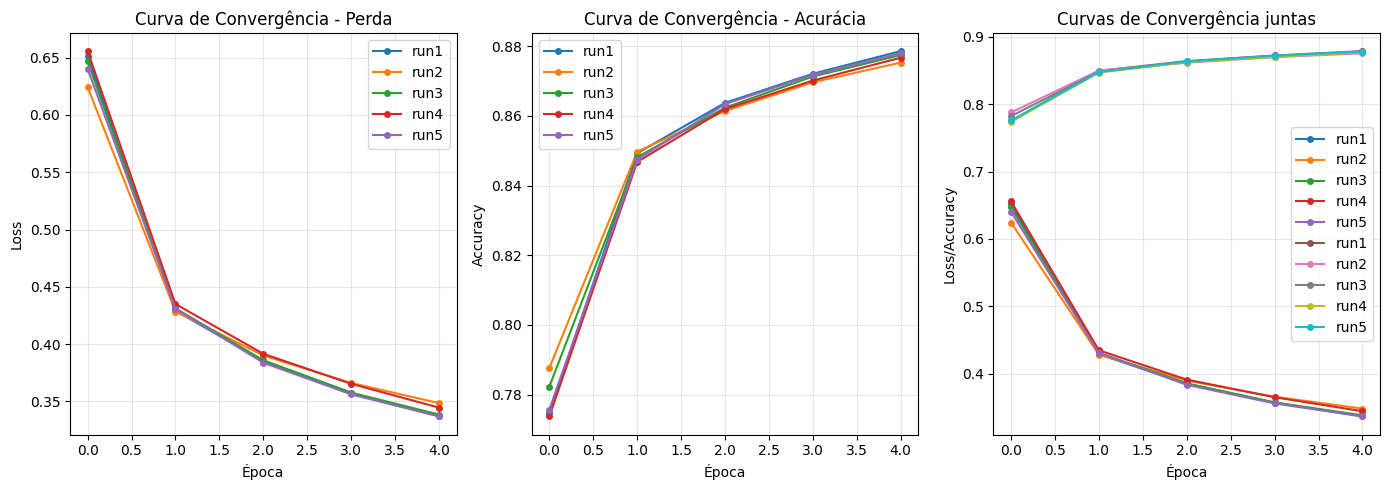


========== ESTABILIDADE ==========
Loss - média: 0.3410
Loss - desvio padrão: 0.0046
accuracy  - média: 0.8772
accuracy  - desvio padrão: 0.0011


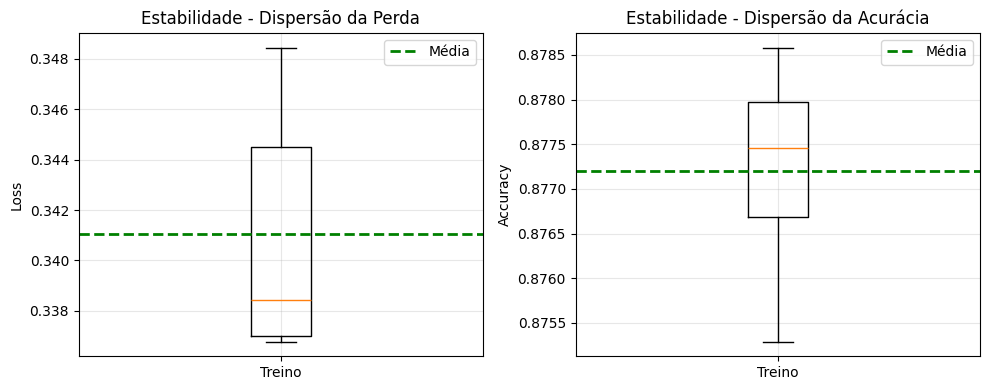


========== DESEMPENHO por seed ==========
Run 1 (seed=702235665): Loss=0.3370, accuracy=0.8786
Run 2 (seed=700584937): Loss=0.3484, accuracy=0.8753
Run 3 (seed=698953509): Loss=0.3384, accuracy=0.8775
Run 4 (seed=697301858): Loss=0.3445, accuracy=0.8767
Run 5 (seed=695645752): Loss=0.3368, accuracy=0.8780


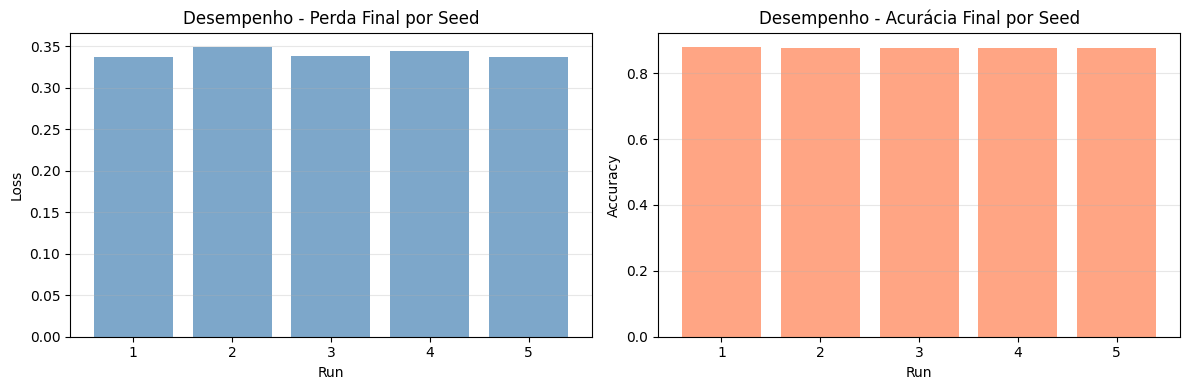


Seeds usadas: [702235665, 700584937, 698953509, 697301858, 695645752]


In [10]:
# ========== CURVAS DE CONVERGÊNCIA ==========
fig, axes = plt.subplots(1, 3, figsize=(14, 5))

print(f"estrutura das histories: {histories[-1].history}")
print("é possível adicionar mais informações no dicionário history, como f1, recall, precision, etc.")

#perda
for i, h in enumerate(histories, start=1):
    axes[0].plot(h.history['loss'], label=f'run{i}', marker='o', markersize=4)
axes[0].set_title('Curva de Convergência - Perda')
axes[0].set_xlabel('Época')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

#acurácia
for i, h in enumerate(histories, start=1):
    axes[1].plot(h.history['accuracy'], label=f'run{i}', marker='o', markersize=4)
axes[1].set_title('Curva de Convergência - Acurácia')
axes[1].set_xlabel('Época')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

#as duas(análise de over/underfitting)
for i, h in enumerate(histories, start=1):
    axes[2].plot(h.history['loss'], label=f'run{i}', marker='o', markersize=4)
for i, h in enumerate(histories, start=1):
    axes[2].plot(h.history['accuracy'], label=f'run{i}', marker='o', markersize=4)
axes[2].set_title('Curvas de Convergência juntas')
axes[2].set_xlabel('Época')
axes[2].set_ylabel('Loss/Accuracy')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
#loss continua alta, accuracy continua baixa -> underfitting
#loss continua caindo mesmo com accuracy estagnada -> overfitting
# ========== ESTABILIDADE ==========
train_losses = [m['final_train_loss'] for m in final_metrics]
train_accuracies = [m['final_train_acc'] for m in final_metrics]

print("\n========== ESTABILIDADE ==========")
print(f"Loss - média: {np.mean(train_losses):.4f}")
print(f"Loss - desvio padrão: {np.std(train_losses):.4f}")
print(f"accuracy  - média: {np.mean(train_accuracies):.4f}")
print(f"accuracy  - desvio padrão: {np.std(train_accuracies):.4f}")

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
#5 seeds divididas entre bigode superior(máximo), limite superior da caixa, linha laranja (mediana), limite inferior da caixa, bigode inferior(mínimo)
axes[0].boxplot(train_losses, whis=(0, 100))
axes[0].set_title('Estabilidade - Dispersão da Perda')
axes[0].set_ylabel('Loss')
axes[0].set_xticklabels(['Treino'])
#axes[0].scatter([1]*len(train_losses), train_losses, color='red', zorder=2)
axes[0].axhline(y=np.mean(train_losses), color='green', linestyle='--', linewidth=2, label='Média')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].boxplot(train_accuracies, whis=(0, 100))
axes[1].set_title('Estabilidade - Dispersão da Acurácia')
axes[1].set_ylabel('Accuracy')
axes[1].set_xticklabels(['Treino'])
#axes[1].scatter([1]*len(train_accuracies), train_accuracies, color='red', zorder=2)
axes[1].axhline(y=np.mean(train_accuracies), color='green', linestyle='--', linewidth=2, label='Média')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ========== DESEMPENHO ==========
print("\n========== DESEMPENHO por seed ==========")
for m in final_metrics:
    print(f"Run {m['run']} (seed={m['seed']}): Loss={m['final_train_loss']:.4f}, accuracy={m['final_train_acc']:.4f}")

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
x = np.arange(1, 6)

axes[0].bar(x, train_losses, alpha=0.7, color='steelblue')
axes[0].set_title('Desempenho - Perda Final por Seed')
axes[0].set_xlabel('Run')
axes[0].set_ylabel('Loss')
axes[0].set_xticks(x)
axes[0].grid(True, alpha=0.3, axis='y')

axes[1].bar(x, train_accuracies, alpha=0.7, color='coral')
axes[1].set_title('Desempenho - Acurácia Final por Seed')
axes[1].set_xlabel('Run')
axes[1].set_ylabel('Accuracy')
axes[1].set_xticks(x)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\nSeeds usadas:", seeds)

### escolha de função de ativação

In [11]:
activation_function_hidden_layer_options = ['relu', 'sigmoid', 'tanh']

### treinamento

In [12]:
#TODO
#TODO
seeds_q1 = spaced_seeds(1, base, PRIME_STEP)
results_q1 = []

for activation_function_hidden_layer in activation_function_hidden_layer_options:
    run_losses = []
    run_accuracies = []

    for s in seeds_q1:
        keras.utils.set_random_seed(s)
        model = build_model(activation_hidden=activation_function_hidden_layer)
        h = model.fit(x_train, y_train, verbose=1)
        run_losses.append(h.history['loss'][-1])
        run_accuracies.append(h.history['accuracy'][-1])
    results_q1.append({
        'activation_function_hidden_layer': activation_function_hidden_layer,
        'loss_mean': float(np.mean(run_losses)),
        'loss_std': float(np.std(run_losses)),
        'accuracy_mean': float(np.mean(run_accuracies)),
        'accuracy_std': float(np.std(run_accuracies))
    })

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.7429 - loss: 0.7397
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6621 - loss: 1.2155
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.7634 - loss: 0.7075


### ordenação

In [13]:
# Ordena por melhor equilíbrio: alta acurácia média, baixa perda média e baixa variância
# Score simples: accuracy_mean - loss_mean - (loss_std + accuracy_std)
sorted_results_q1 = sorted(
    results_q1,
    key=lambda sorted_result: (-(sorted_result['accuracy_mean']), sorted_result['loss_mean'], sorted_result['loss_std'] + sorted_result['accuracy_std'])
)

print("Funções de ativação(melhor pra pior):")
for i,sorted_result in enumerate(sorted_results_q1[:3]):
    print(
        f"{i+1}. activation_function_hidden_layer={sorted_result['activation_function_hidden_layer']}"
    )

Funções de ativação(melhor pra pior):
1. activation_function_hidden_layer=tanh
2. activation_function_hidden_layer=relu
3. activation_function_hidden_layer=sigmoid


# Questão 02: hiperparâmetros

### parâmetros ajustados

In [14]:
#TODO: mais opcões de hiperparâmetros para teste exaustivo final
num_epochs_grid = [5, 10, 20]
learning_rates = [1e-4, 1e-3, 1e-2]
batch_sizes = [64, 128, 256]
momentums_beta1 = [0.7, 0.9, 0.99]

### treinamento

In [15]:
#TODO: aumentar número de seeds para teste exaustivo final
#TODO: treino e validação
import time

seeds_q2 = spaced_seeds(1, base, PRIME_STEP)
results_q2 = []  # lista de dicts com hiperparâmetros e métricas agregadas
histories_q2 = []

for epochs in num_epochs_grid:
    for learning_rate in learning_rates:
        for batch_size in batch_sizes:
            for beta1 in momentums_beta1:
                run_losses = []
                run_accuracies = []
                run_times = []

                for s in seeds_q2:
                    keras.utils.set_random_seed(s)
                    model = build_model(learning_rate=learning_rate, beta1=beta1)

                    # Mede tempo de treinamento
                    start_time = time.time()
                    h = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)
                    training_time = time.time() - start_time

                    histories_q2.append(h)
                    run_losses.append(h.history['loss'][-1])
                    run_accuracies.append(h.history['accuracy'][-1])
                    run_times.append(training_time)

                results_q2.append({
                    'epochs': epochs,
                    'learning_rate': learning_rate,
                    'batch_size': batch_size,
                    'beta1': beta1,
                    'loss_mean': float(np.mean(run_losses)),
                    'loss_std': float(np.std(run_losses)),
                    'accuracy_mean': float(np.mean(run_accuracies)),
                    'accuracy_std': float(np.std(run_accuracies)),
                    'time_mean': float(np.mean(run_times)),
                    'time_std': float(np.std(run_times))
                })

print(f"\n✓ Treinamento Q2 concluído: {len(results_q2)} combinações testadas")

Epoch 1/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5507 - loss: 1.4557
Epoch 2/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8052 - loss: 0.5879
Epoch 3/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8314 - loss: 0.5014
Epoch 4/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8416 - loss: 0.4614
Epoch 5/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8488 - loss: 0.4354
Epoch 1/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5396 - loss: 1.4840
Epoch 2/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8039 - loss: 0.5888
Epoch 3/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8299 - loss: 0.5039
Epoch 4/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8402 - loss: 0.4648
Epoch 5/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8477 - loss: 0.4391
Epoch 1/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.4975 - loss: 1.5766
Epoch 2/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.

### ordenação

In [16]:
# Ordena por melhor equilíbrio: alta acurácia média, baixa perda média e baixa variância
# Score simples: accuracy_mean - loss_mean - (loss_std + accuracy_std)
sorted_results_q2 = sorted(
    results_q2,
    key=lambda sorted_result: (-(sorted_result['accuracy_mean']), sorted_result['loss_mean'], sorted_result['loss_std'] + sorted_result['accuracy_std'])
)

print("Top 10 melhores combinações (melhor pro pior):")
for i,sorted_result in enumerate(sorted_results_q2[:10]):
    print(
        f"{i+1}. epochs={sorted_result['epochs']}, learning_rate={sorted_result['learning_rate']},"
        f" batch={sorted_result['batch_size']}, beta1={sorted_result['beta1']} | "
        f"loss_mean={sorted_result['loss_mean']:.4f} (±{sorted_result['loss_std']:.4f}), "
        f"accuracy_mean={sorted_result['accuracy_mean']:.4f} (±{sorted_result['accuracy_std']:.4f})"
    )

print("\n\nTop 10 piores combinações (melhor pro pior):")
for i,sorted_result in enumerate(sorted_results_q2[-10:-1]):
    print(
        f"{i+1}. epochs={sorted_result['epochs']}, learning_rate={sorted_result['learning_rate']},"
        f" batch={sorted_result['batch_size']}, beta1={sorted_result['beta1']} | "
        f"loss_mean={sorted_result['loss_mean']:.4f} (±{sorted_result['loss_std']:.4f}), "
        f"accuracy_mean={sorted_result['accuracy_mean']:.4f} (±{sorted_result['accuracy_std']:.4f})"
    )

Top 10 melhores combinações (melhor pro pior):
1. epochs=20, learning_rate=0.001, batch=64, beta1=0.9 | loss_mean=0.1995 (±0.0000), accuracy_mean=0.9252 (±0.0000)
2. epochs=20, learning_rate=0.001, batch=64, beta1=0.7 | loss_mean=0.2001 (±0.0000), accuracy_mean=0.9250 (±0.0000)
3. epochs=20, learning_rate=0.001, batch=128, beta1=0.7 | loss_mean=0.2119 (±0.0000), accuracy_mean=0.9222 (±0.0000)
4. epochs=20, learning_rate=0.001, batch=128, beta1=0.9 | loss_mean=0.2198 (±0.0000), accuracy_mean=0.9190 (±0.0000)
5. epochs=20, learning_rate=0.001, batch=64, beta1=0.99 | loss_mean=0.2298 (±0.0000), accuracy_mean=0.9154 (±0.0000)
6. epochs=20, learning_rate=0.001, batch=256, beta1=0.7 | loss_mean=0.2329 (±0.0000), accuracy_mean=0.9149 (±0.0000)
7. epochs=20, learning_rate=0.001, batch=256, beta1=0.9 | loss_mean=0.2418 (±0.0000), accuracy_mean=0.9121 (±0.0000)
8. epochs=20, learning_rate=0.001, batch=128, beta1=0.99 | loss_mean=0.2442 (±0.0000), accuracy_mean=0.9091 (±0.0000)
9. epochs=20, lear

### comparações

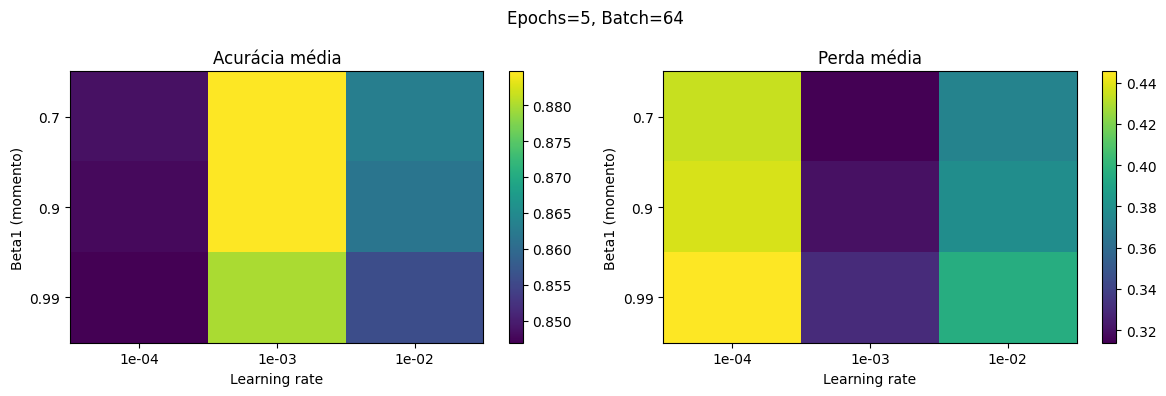

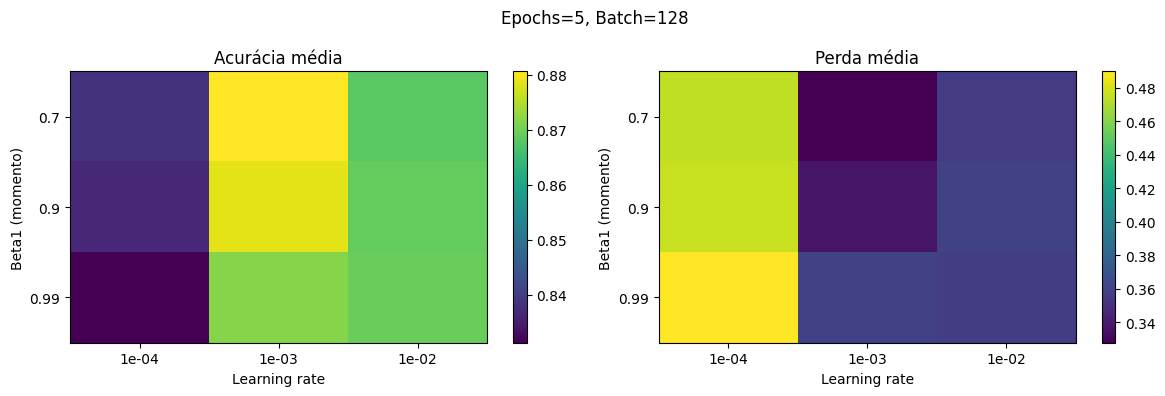

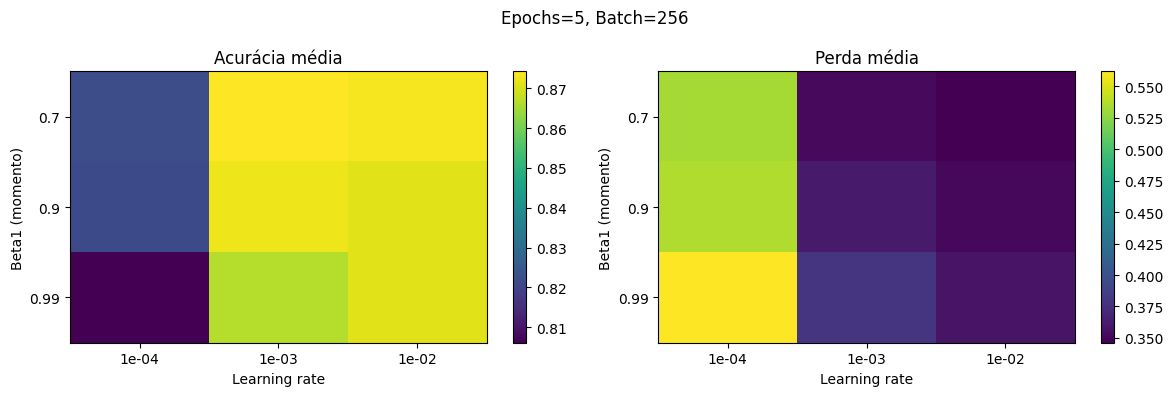

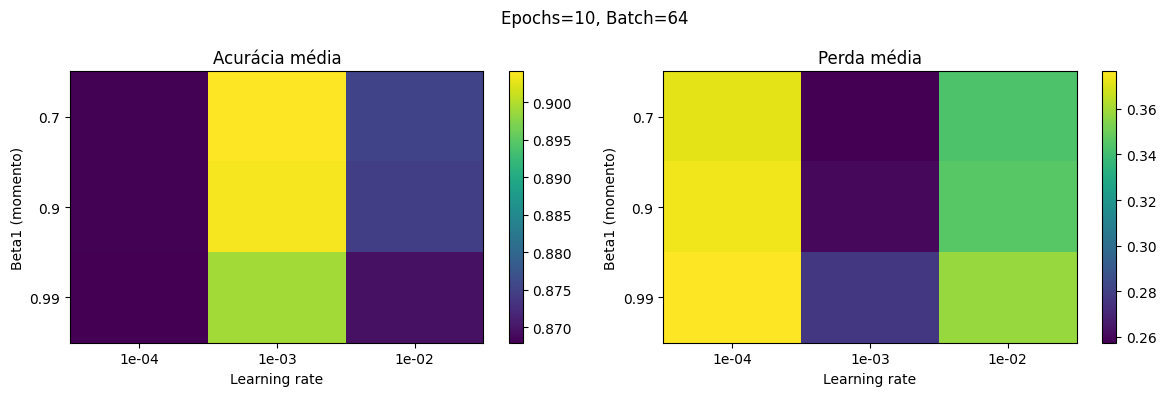

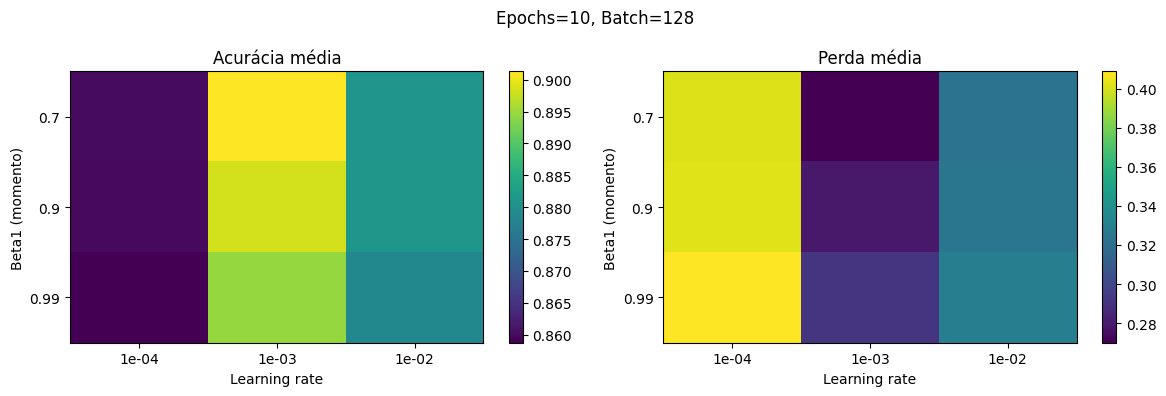

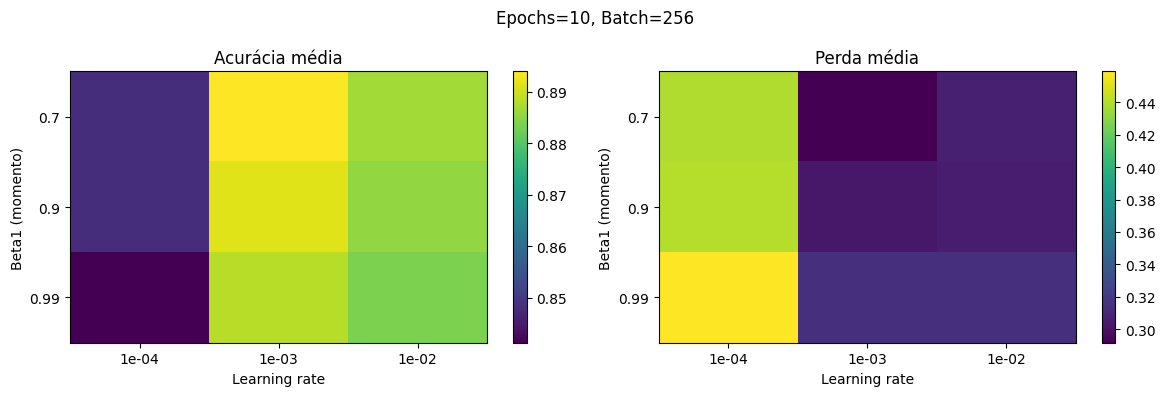

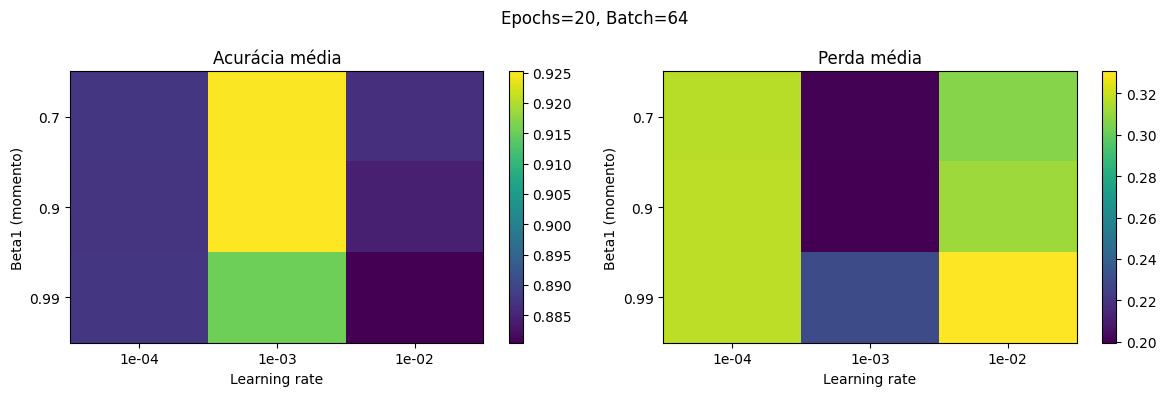

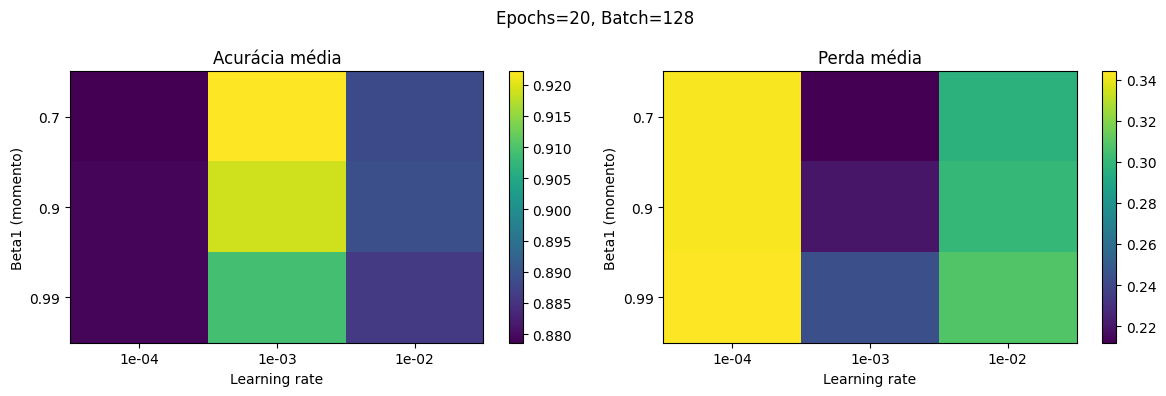

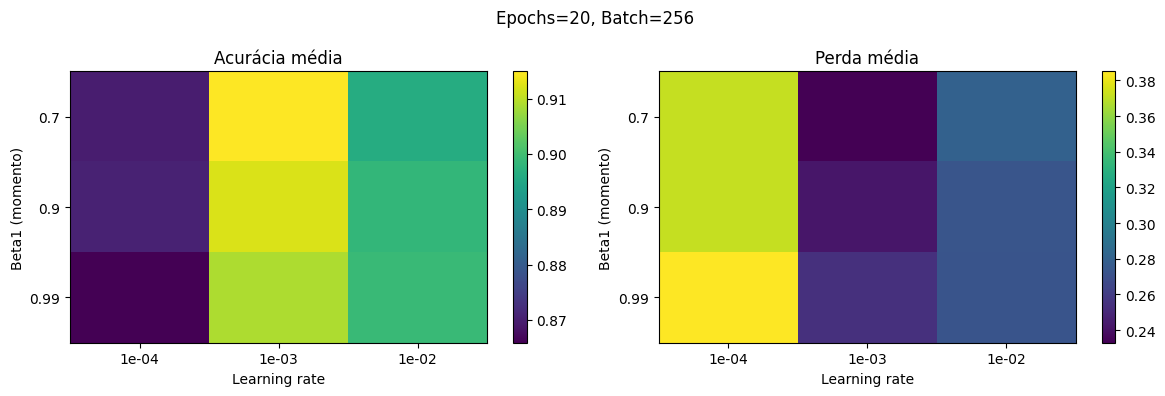

In [17]:
# Loop sobre epochs e batch_size: para cada combinação, gera mapas de calor 2D (beta1 x learning_rate)
# usando as métricas agregadas em `results`.

# Conjuntos ordenados de parâmetros disponíveis em `results`
unique_epochs = sorted(list({r['epochs'] for r in results_q2}))
unique_batch_sizes = sorted(list({r['batch_size'] for r in results_q2}))
unique_beta1s = sorted(list({r['beta1'] for r in results_q2}))
unique_learning_rates = sorted(list({r['learning_rate'] for r in results_q2}))

# Para cada (epochs, batch_size), monta matrizes 2D [beta1 x lr] de acurácia e perda
for epochs in unique_epochs:
    for batch_size in unique_batch_sizes:
        # Filtra resultados referentes à combinação fixa (epochs, batch_size)
        subset = [r for r in results_q2 if r['epochs'] == epochs and r['batch_size'] == batch_size]
        if not subset:
            continue
        # Índices para mapeamento beta1 x lr
        b1_index = {b1: i for i, b1 in enumerate(unique_beta1s)}
        lr_index = {lr: j for j, lr in enumerate(unique_learning_rates)}

        accuracy_matrix = np.full((len(unique_beta1s), len(unique_learning_rates)), np.nan)
        loss_matrix = np.full((len(unique_beta1s), len(unique_learning_rates)), np.nan)

        for r in subset:
            i = b1_index[r['beta1']]
            j = lr_index[r['learning_rate']]
            accuracy_matrix[i, j] = r['accuracy_mean']
            loss_matrix[i, j] = r['loss_mean']

        # Visualização dos mapas de calor
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        fig.suptitle(f"Epochs={epochs}, Batch={batch_size}")

        im0 = axes[0].imshow(accuracy_matrix, cmap='viridis', aspect='auto')
        axes[0].set_title('Acurácia média')
        axes[0].set_xticks(range(len(unique_learning_rates)))
        axes[0].set_xticklabels([f"{lr:.0e}" for lr in unique_learning_rates])
        axes[0].set_yticks(range(len(unique_beta1s)))
        axes[0].set_yticklabels([str(b1) for b1 in unique_beta1s])
        axes[0].set_xlabel('Learning rate')
        axes[0].set_ylabel('Beta1 (momento)')
        plt.colorbar(im0, ax=axes[0])

        im1 = axes[1].imshow(loss_matrix, cmap='viridis', aspect='auto')
        axes[1].set_title('Perda média')
        axes[1].set_xticks(range(len(unique_learning_rates)))
        axes[1].set_xticklabels([f"{lr:.0e}" for lr in unique_learning_rates])
        axes[1].set_yticks(range(len(unique_beta1s)))
        axes[1].set_yticklabels([str(b1) for b1 in unique_beta1s])
        axes[1].set_xlabel('Learning rate')
        axes[1].set_ylabel('Beta1 (momento)')
        plt.colorbar(im1, ax=axes[1])

        plt.tight_layout()
        plt.show()
#esperado: loss com cores invertidas de accuracy -> equilibrados

### visualização alternativa

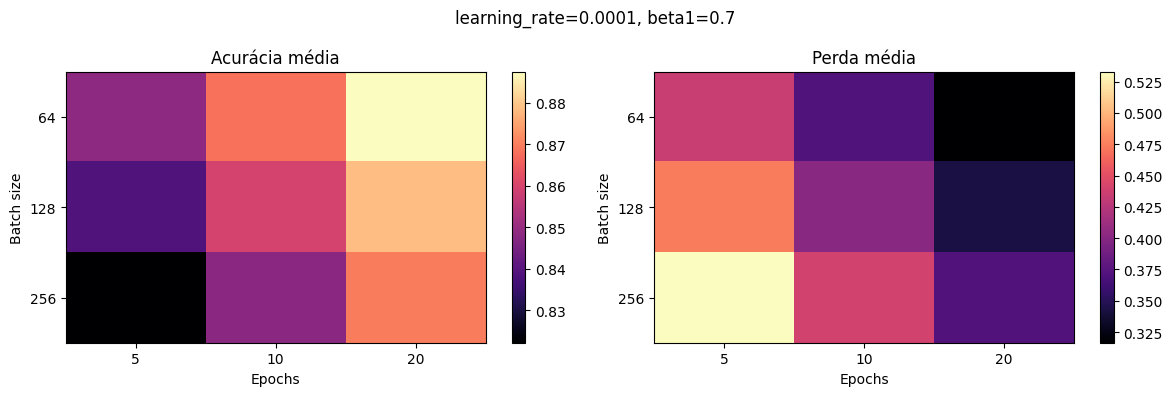

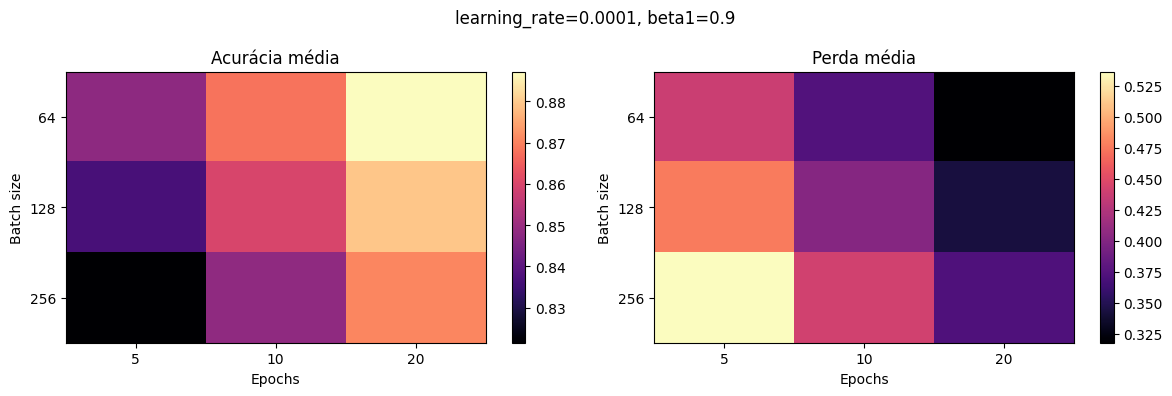

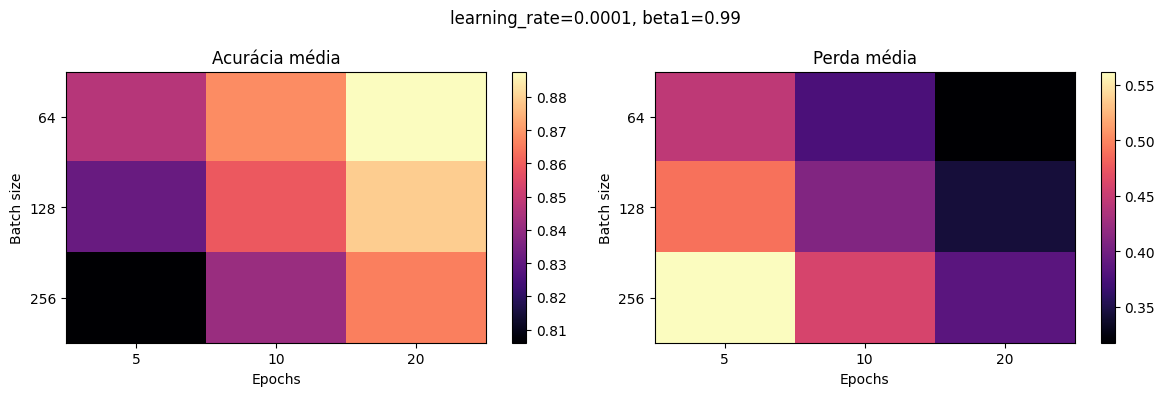

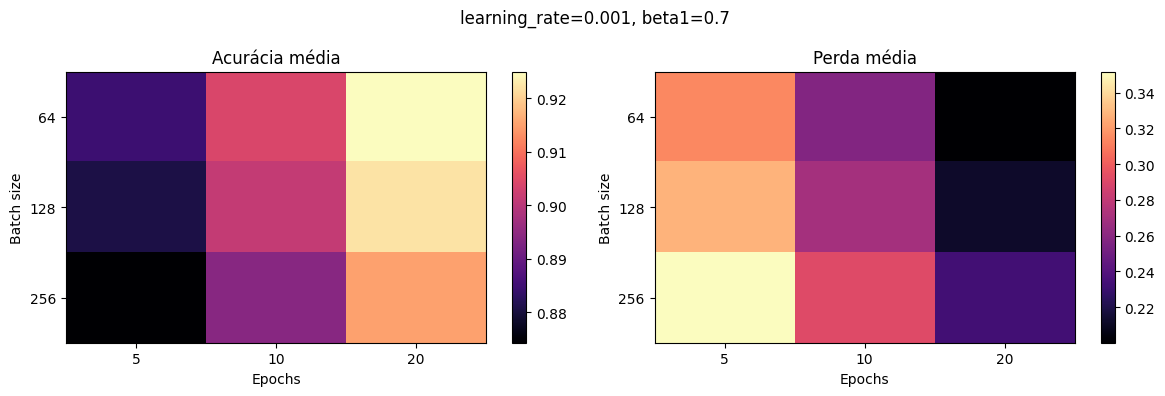

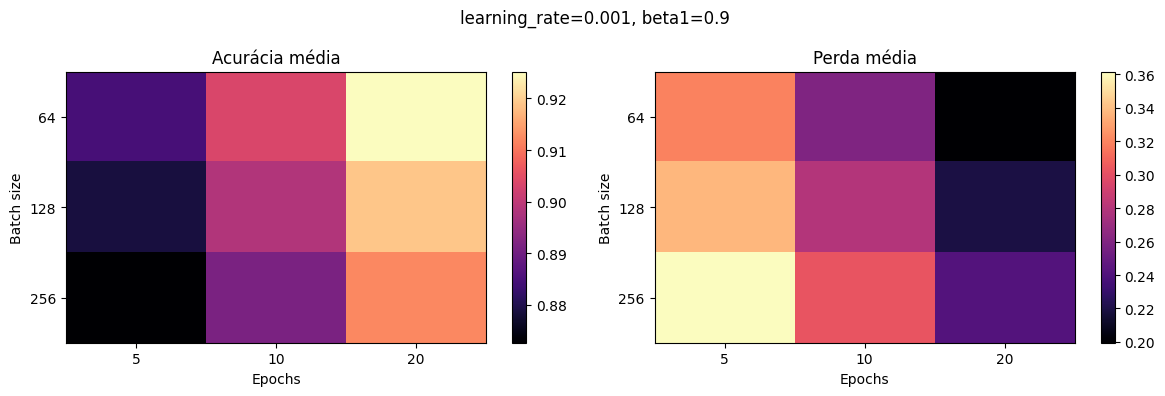

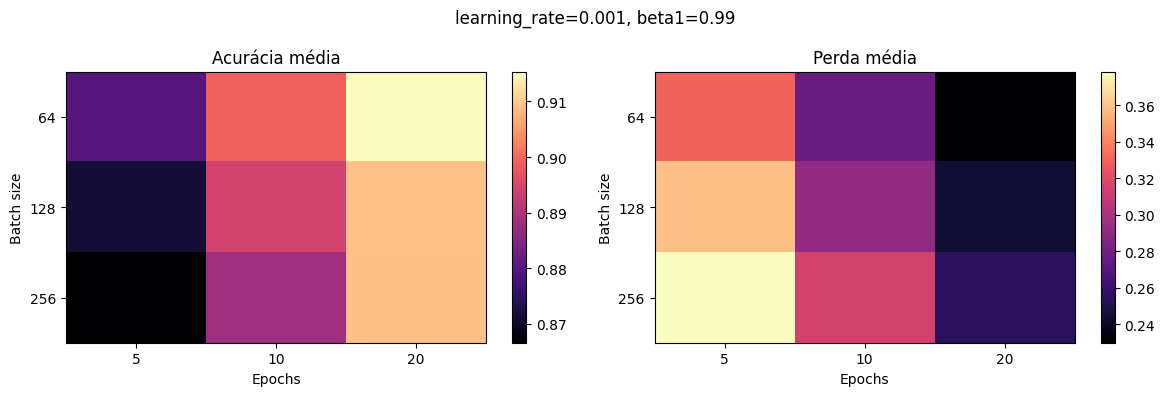

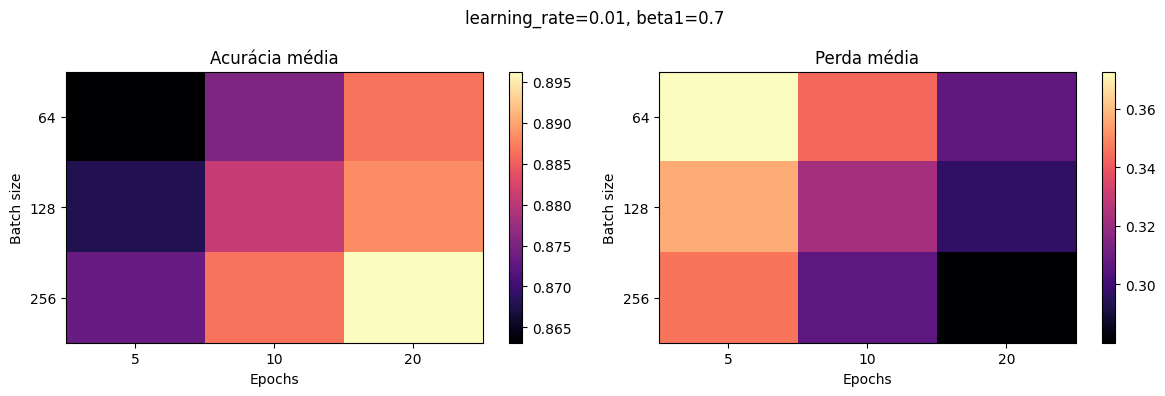

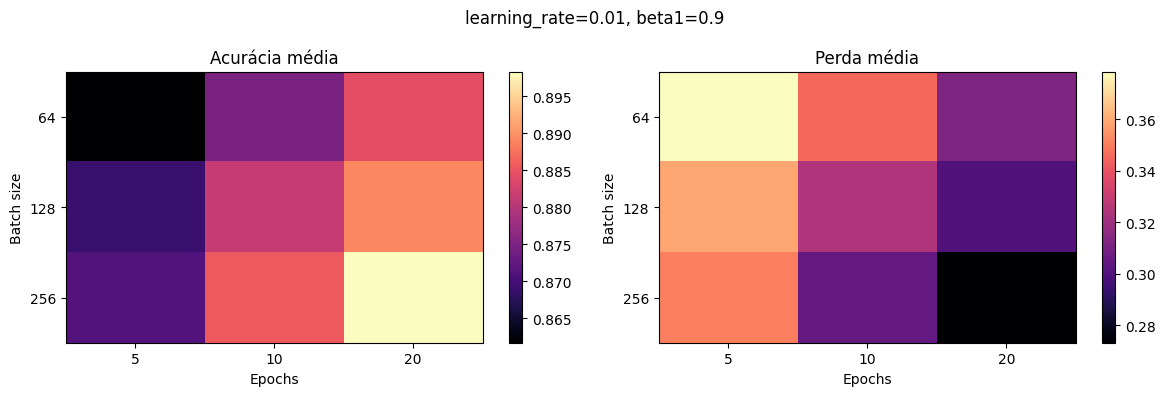

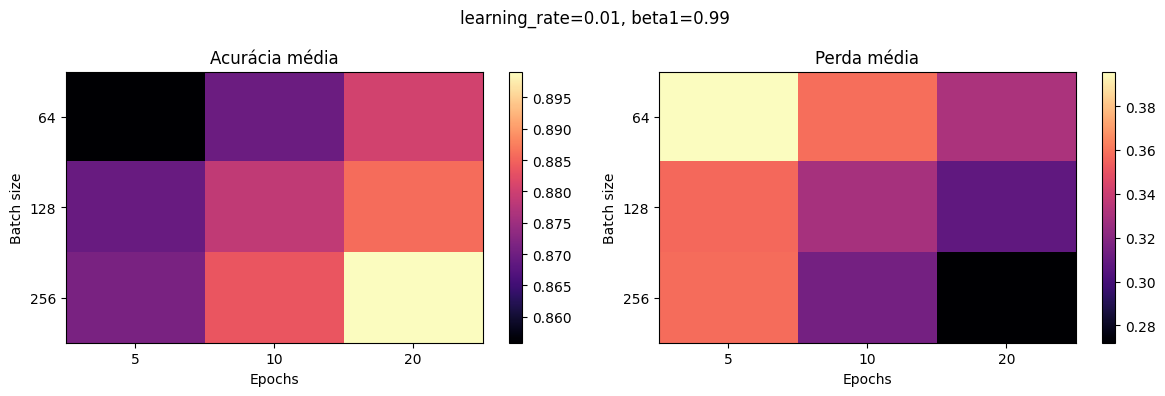

In [18]:
# Para cada (lr, beta1), monta matrizes 2D [epoch x batch_size] de acurácia e perda
for learning_rate in unique_learning_rates:
    for beta1 in unique_beta1s:
        # Filtra resultados referentes à combinação fixa (epochs, batch_size)
        subset = [r for r in results_q2 if r['learning_rate'] == learning_rate and r['beta1'] == beta1]
        if not subset:
            continue
        # Índices para mapeamento beta1 x lr
        ba_index = {ba: i for i, ba in enumerate(unique_batch_sizes)}
        ep_index = {ep: j for j, ep in enumerate(unique_epochs)}

        accuracy_matrix = np.full((len(unique_batch_sizes), len(unique_epochs)), np.nan)
        loss_matrix = np.full((len(unique_batch_sizes), len(unique_epochs)), np.nan)

        for r in subset:
            i = ba_index[r['batch_size']]
            j = ep_index[r['epochs']]
            accuracy_matrix[i, j] = r['accuracy_mean']
            loss_matrix[i, j] = r['loss_mean']

        # Visualização dos mapas de calor
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        fig.suptitle(f"learning_rate={learning_rate}, beta1={beta1}")

        im0 = axes[0].imshow(accuracy_matrix, cmap='magma', aspect='auto')
        axes[0].set_title('Acurácia média')
        axes[0].set_xticks(range(len(unique_epochs)))
        axes[0].set_xticklabels([str(ep) for ep in unique_epochs])
        axes[0].set_yticks(range(len(unique_batch_sizes)))
        axes[0].set_yticklabels([str(b) for b in unique_batch_sizes])
        axes[0].set_xlabel('Epochs')
        axes[0].set_ylabel('Batch size')
        plt.colorbar(im0, ax=axes[0])

        im1 = axes[1].imshow(loss_matrix, cmap='magma', aspect='auto')
        axes[1].set_title('Perda média')
        axes[1].set_xticks(range(len(unique_epochs)))
        axes[1].set_xticklabels([str(ep) for ep in unique_epochs])
        axes[1].set_yticks(range(len(unique_batch_sizes)))
        axes[1].set_yticklabels([str(b) for b in unique_batch_sizes])
        axes[1].set_xlabel('Epochs')
        axes[1].set_ylabel('Batch size')
        plt.colorbar(im1, ax=axes[1])

        plt.tight_layout()
        plt.show()

### métricas

Total de combinações testadas: 81
========== CURVAS DE CONVERGÊNCIA ==========


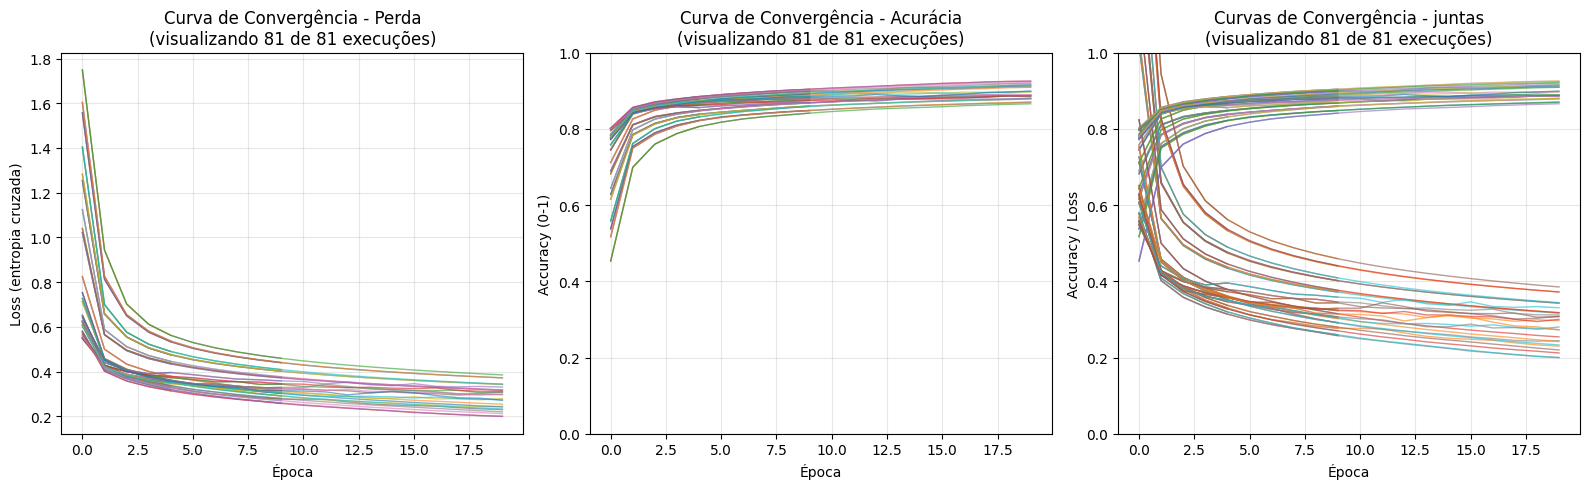


========== ESTABILIDADE (n=5) ==========


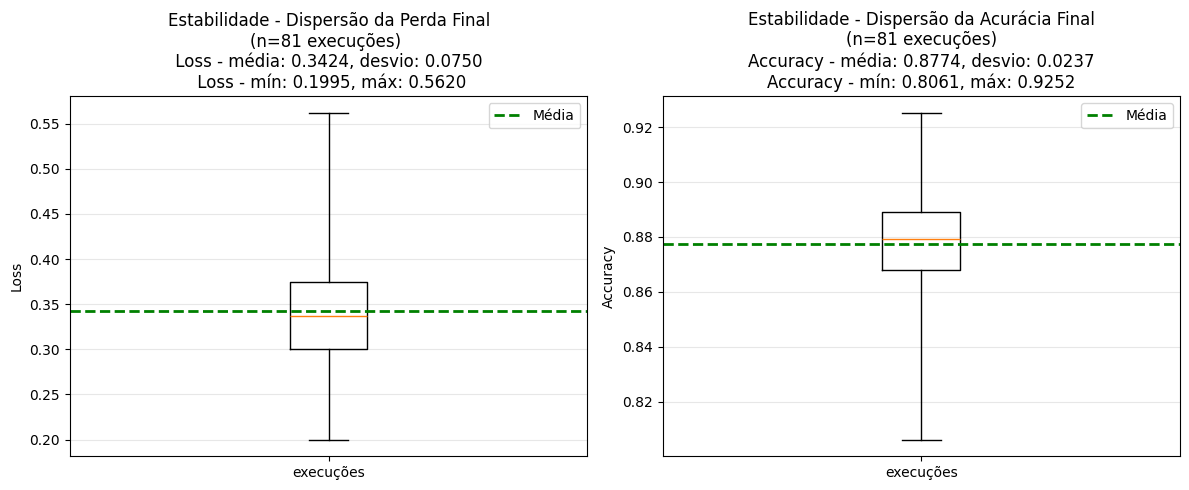


========== TEMPO DE TREINAMENTO ==========
Tempo médio geral: 16.57s (±11.43s)
Tempo mínimo: 4.82s
Tempo máximo: 45.92s

Tempo médio por número de épocas:
  5 épocas: 8.01s (±2.48s)
  10 épocas: 13.88s (±5.41s)
  20 épocas: 27.83s (±12.23s)


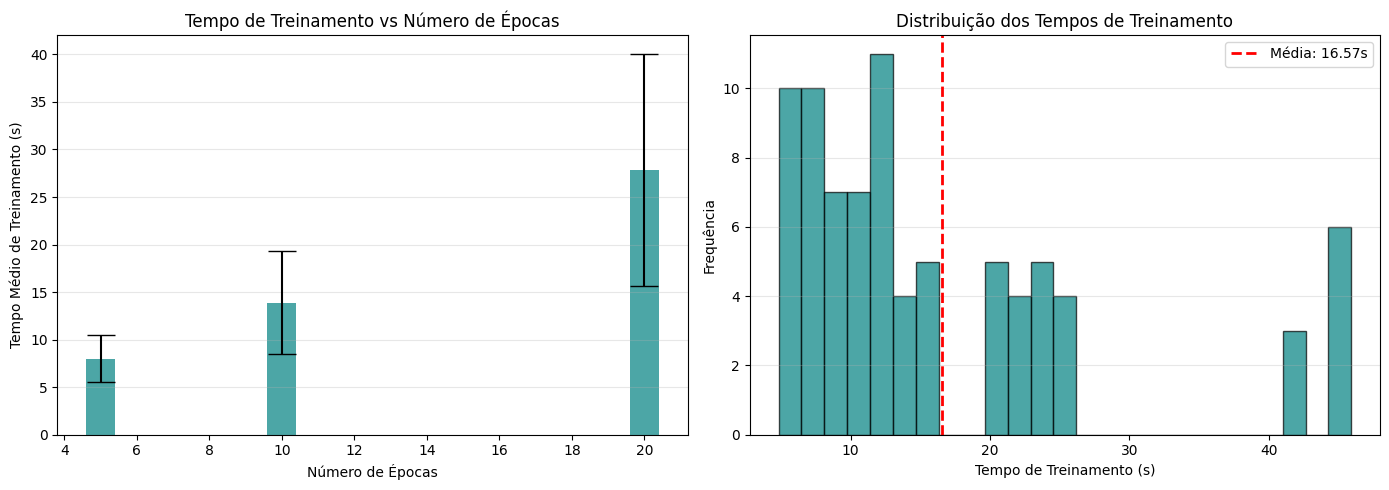


========== TOP 5 COMBINAÇÕES MAIS RÁPIDAS ==========
1. Tempo: 4.82s | epochs=5, lr=0.0001, batch=256, beta1=0.9
   Loss: 0.5363, Acc: 0.8215
2. Tempo: 4.94s | epochs=5, lr=0.001, batch=256, beta1=0.9
   Loss: 0.3616, Acc: 0.8726
3. Tempo: 5.12s | epochs=5, lr=0.01, batch=256, beta1=0.9
   Loss: 0.3505, Acc: 0.8711
4. Tempo: 5.60s | epochs=5, lr=0.001, batch=256, beta1=0.99
   Loss: 0.3784, Acc: 0.8666
5. Tempo: 5.69s | epochs=5, lr=0.01, batch=256, beta1=0.7
   Loss: 0.3462, Acc: 0.8734

========== TOP 5 COMBINAÇÕES MAIS LENTAS ==========
1. Tempo: 44.67s | epochs=20, lr=0.0001, batch=64, beta1=0.7
   Loss: 0.3165, Acc: 0.8875
2. Tempo: 44.72s | epochs=20, lr=0.01, batch=64, beta1=0.9
   Loss: 0.3116, Acc: 0.8843
3. Tempo: 45.55s | epochs=20, lr=0.01, batch=64, beta1=0.7
   Loss: 0.3070, Acc: 0.8867
4. Tempo: 45.83s | epochs=20, lr=0.01, batch=64, beta1=0.99
   Loss: 0.3306, Acc: 0.8805
5. Tempo: 45.92s | epochs=20, lr=0.001, batch=64, beta1=0.99
   Loss: 0.2298, Acc: 0.9154


In [19]:
print(f"Total de combinações testadas: {len(results_q2)}")


print("========== CURVAS DE CONVERGÊNCIA ==========")
sample_step = 1 # mostra modelos 1 a 1, ajuste para visualização menos poluída
sample_indices = list(range(0, len(histories_q2), sample_step)) #start, stop, step

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

#perda
for idx in sample_indices:
    h = histories_q2[idx]
    axes[0].plot(h.history['loss'], alpha=0.6, linewidth=1)
axes[0].set_title(f'Curva de Convergência - Perda\n(visualizando {len(sample_indices)} de {len(histories_q2)} execuções)')
axes[0].set_xlabel('Época')
axes[0].set_ylabel('Loss (entropia cruzada)')
axes[0].grid(True, alpha=0.3)

#acurácia
for idx in sample_indices:
    h = histories_q2[idx]
    axes[1].plot(h.history['accuracy'], alpha=0.6, linewidth=1)
axes[1].set_title(f'Curva de Convergência - Acurácia\n(visualizando {len(sample_indices)} de {len(histories_q2)} execuções)')
axes[1].set_xlabel('Época')
axes[1].set_ylabel('Accuracy (0-1)')
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim([0, 1])

#as duas
for idx in sample_indices:
    h = histories_q2[idx]
    axes[2].plot(h.history['accuracy'], alpha=0.6, linewidth=1)
    axes[2].plot(h.history['loss'], alpha=0.6, linewidth=1)
axes[2].set_title(f'Curvas de Convergência - juntas\n(visualizando {len(sample_indices)} de {len(histories_q2)} execuções)')
axes[2].set_xlabel('Época')
axes[2].set_ylabel('Accuracy / Loss')
axes[2].grid(True, alpha=0.3)
axes[2].set_ylim([0, 1])

plt.tight_layout()
plt.show()


print(f"\n========== ESTABILIDADE (n={len(train_losses)}) ==========")
train_losses = [h.history['loss'][-1] for h in histories_q2]
train_accuracies = [h.history['accuracy'][-1] for h in histories_q2]


fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Boxplot de Loss
axes[0].boxplot(train_losses, whis=(0, 100))
axes[0].set_title(f'Estabilidade - Dispersão da Perda Final\n(n={len(train_losses)} execuções) '
                  f'\n Loss - média: {np.mean(train_losses):.4f}, desvio: {np.std(train_losses):.4f} '
                  f'\n Loss - mín: {np.min(train_losses):.4f}, máx: {np.max(train_losses):.4f}')
axes[0].set_ylabel('Loss')
axes[0].set_xticklabels(['execuções'])
axes[0].axhline(y=np.mean(train_losses), color='green', linestyle='--', linewidth=2, label='Média')
#pontos individuais
#axes[0].scatter([1]*len(train_losses), train_losses, color='red', zorder=2)
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# Boxplot de Accuracy
axes[1].boxplot(train_accuracies, whis=(0, 100))
axes[1].set_title(f'Estabilidade - Dispersão da Acurácia Final\n(n={len(train_accuracies)} execuções)'
                  f'\nAccuracy - média: {np.mean(train_accuracies):.4f}, desvio: {np.std(train_accuracies):.4f}'
                  f'\nAccuracy - mín: {np.min(train_accuracies):.4f}, máx: {np.max(train_accuracies):.4f}')
axes[1].set_ylabel('Accuracy')
axes[1].set_xticklabels(['execuções'])
axes[1].axhline(y=np.mean(train_accuracies), color='green', linestyle='--', linewidth=2, label='Média')
#pontos individuais
#axes[1].scatter([1]*len(train_accuracies), train_accuracies, color='red', zorder=2)
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


print("\n========== TEMPO DE TREINAMENTO ==========")

all_times = [r['time_mean'] for r in results_q2]
all_time_stds = [r['time_std'] for r in results_q2]
#média e desvio do tempo de execução do mesmo modelo para todas as seeds

print(f"Tempo médio geral: {np.mean(all_times):.2f}s (±{np.std(all_times):.2f}s)")
print(f"Tempo mínimo: {np.min(all_times):.2f}s")
print(f"Tempo máximo: {np.max(all_times):.2f}s")

#tempo por quantidade total de épocas do modelo
time_by_epochs = {}
for r in results_q2:
    ep = r['epochs']
    if ep not in time_by_epochs:
        time_by_epochs[ep] = []
    time_by_epochs[ep].append(r['time_mean'])

print("\nTempo médio por número de épocas:")
for ep in sorted(time_by_epochs.keys()):
    print(f"  {ep} épocas: {np.mean(time_by_epochs[ep]):.2f}s (±{np.std(time_by_epochs[ep]):.2f}s)")

# Gráfico de tempo por épocas
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

epochs_list = sorted(time_by_epochs.keys())
mean_times = [np.mean(time_by_epochs[ep]) for ep in epochs_list]
std_times = [np.std(time_by_epochs[ep]) for ep in epochs_list]

axes[0].set_title('Tempo de Treinamento vs Número de Épocas')
axes[0].bar(epochs_list, mean_times, yerr=std_times, alpha=0.7, capsize=10, color='teal')
axes[0].set_xlabel('Número de Épocas')
axes[0].set_ylabel('Tempo Médio de Treinamento (s)')
axes[0].grid(True, alpha=0.3, axis='y')


axes[1].set_title('Distribuição dos Tempos de Treinamento')
axes[1].hist(all_times, bins=25, alpha=0.7, color='teal', edgecolor='black')
axes[1].axvline(np.mean(all_times), color='red', linestyle='--', linewidth=2, label=f'Média: {np.mean(all_times):.2f}s')
axes[1].set_xlabel('Tempo de Treinamento (s)')
axes[1].set_ylabel('Frequência')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


print("\n========== TOP 5 COMBINAÇÕES MAIS RÁPIDAS ==========")
sorted_by_time = sorted(results_q2, key=lambda x: x['time_mean'])
for i, r in enumerate(sorted_by_time[:5], 1):
    print(f"{i}. Tempo: {r['time_mean']:.2f}s | epochs={r['epochs']}, lr={r['learning_rate']}, "
          f"batch={r['batch_size']}, beta1={r['beta1']}")
    print(f"   Loss: {r['loss_mean']:.4f}, Acc: {r['accuracy_mean']:.4f}")

print("\n========== TOP 5 COMBINAÇÕES MAIS LENTAS ==========")
for i, r in enumerate(sorted_by_time[-5:], 1):
    print(f"{i}. Tempo: {r['time_mean']:.2f}s | epochs={r['epochs']}, lr={r['learning_rate']}, "
          f"batch={r['batch_size']}, beta1={r['beta1']}")
    print(f"   Loss: {r['loss_mean']:.4f}, Acc: {r['accuracy_mean']:.4f}")

# Questão 03: topologia

### Parâmetros ajustados

In [20]:
num_hidden_layers_options = [1, 2, 3]
neurons_per_layer_options = {
    1: [[64], [128], [256]],
    2: [[64, 32], [128, 64], [256, 128]],
    3: [[128, 64, 32], [256, 128, 64], [512, 256, 128]]
}

### treinamento

In [21]:
#TODO: aumentar número de seeds para teste exaustivo final
#TODO: treino e validação
import time
from sklearn.metrics import f1_score, precision_score, recall_score

seeds_q3 = spaced_seeds(1, base, PRIME_STEP)
results_q3 = []
histories_q3 = []

for num_hidden_layers in num_hidden_layers_options:
    for neurons_per_layer in neurons_per_layer_options[num_hidden_layers]:
        run_losses = []
        run_accuracies = []
        run_times = []
        run_f1_scores = []
        run_precisions = []
        run_recalls = []

        for s in seeds_q3:
            keras.utils.set_random_seed(s)
            model = build_model(learning_rate=0.001, beta1=0.7, num_hidden_layers=num_hidden_layers, neurons_per_layer=neurons_per_layer)

            start_time = time.time()
            h = model.fit(x_train, y_train, epochs=20, batch_size=64, verbose=0)
            training_time = time.time() - start_time

            #predição necessária para métricas adicionai
            y_pred = model.predict(x_train, verbose=0)
            y_pred_classes = np.argmax(y_pred, axis=1)

            f1 = f1_score(y_train, y_pred_classes, average='weighted')
            precision = precision_score(y_train, y_pred_classes, average='weighted', zero_division=0)
            recall = recall_score(y_train, y_pred_classes, average='weighted')

            run_losses.append(h.history['loss'][-1])
            run_accuracies.append(h.history['accuracy'][-1])
            run_times.append(training_time)
            run_f1_scores.append(f1)
            run_precisions.append(precision)
            run_recalls.append(recall)
            #TODO
            histories_q3.append({
                'history': h,
                'num_hidden_layers': num_hidden_layers,
                'neurons_per_layer': neurons_per_layer
            })

        results_q3.append({
            'number of hidden layers': num_hidden_layers,
            'neurons per layer': neurons_per_layer,
            'loss_mean': float(np.mean(run_losses)),
            'loss_std': float(np.std(run_losses)),
            'accuracy_mean': float(np.mean(run_accuracies)),
            'accuracy_std': float(np.std(run_accuracies)),
            'time_mean': float(np.mean(run_times)),
            'time_std': float(np.std(run_times)),
            'f1_mean': float(np.mean(run_f1_scores)),
            'f1_std': float(np.std(run_f1_scores)),
            'precision_mean': float(np.mean(run_precisions)),
            'precision_std': float(np.std(run_precisions)),
            'recall_mean': float(np.mean(run_recalls)),
            'recall_std': float(np.std(run_recalls))
        })

### Ordenação

In [22]:
# Ordena por melhor equilíbrio: alta acurácia média, baixa perda média e baixa variância
# Score simples: accuracy_mean - loss_mean - (loss_std + accuracy_std)
#9 combinações possíveis
sorted_results_q3 = sorted(
    results_q3,
    key=lambda sorted_result_q3: (-(sorted_result_q3['accuracy_mean']), sorted_result_q3['loss_mean'], sorted_result_q3['loss_std'] + sorted_result_q3['accuracy_std'])
)

print("Top combinações (ordem decrescente):")
for i,sorted_result_q3 in enumerate(sorted_results_q3):
    print(
        f"\n{i+1}.number of hidden layers={sorted_result_q3['number of hidden layers']}"
        f" | neurons per layer={sorted_result_q3['neurons per layer']}"
        f"\n    loss_mean={sorted_result_q3['loss_mean']:.4f} (±{sorted_result_q3['loss_std']:.4f}), "
        f"\n    accuracy_mean={sorted_result_q3['accuracy_mean']:.4f} (±{sorted_result_q3['accuracy_std']:.4f})"
        "\n----------Não considerados para ordenação----------"
        f"\n    time_mean={sorted_result_q3['time_mean']:.2f}s (±{sorted_result_q3['time_std']:.2f}s)"
        f"\n    F1={sorted_result_q3['f1_mean']:.4f} (±{sorted_result_q3['f1_std']:.4f})"
        f"\n    Precision={sorted_result_q3['precision_mean']:.4f} (±{sorted_result_q3['precision_std']:.4f})"
        f"\n    Recall={sorted_result_q3['recall_mean']:.4f} (±{sorted_result_q3['recall_std']:.4f})"
    )

Top combinações (ordem decrescente):

1.number of hidden layers=2 | neurons per layer=[256, 128]
    loss_mean=0.1319 (±0.0000), 
    accuracy_mean=0.9491 (±0.0000)
----------Não considerados para ordenação----------
    time_mean=35.45s (±0.00s)
    F1=0.9276 (±0.0000)
    Precision=0.9287 (±0.0000)
    Recall=0.9286 (±0.0000)

2.number of hidden layers=1 | neurons per layer=[256]
    loss_mean=0.1441 (±0.0000), 
    accuracy_mean=0.9472 (±0.0000)
----------Não considerados para ordenação----------
    time_mean=33.67s (±0.00s)
    F1=0.9277 (±0.0000)
    Precision=0.9304 (±0.0000)
    Recall=0.9284 (±0.0000)

3.number of hidden layers=3 | neurons per layer=[512, 256, 128]
    loss_mean=0.1362 (±0.0000), 
    accuracy_mean=0.9469 (±0.0000)
----------Não considerados para ordenação----------
    time_mean=38.54s (±0.00s)
    F1=0.9127 (±0.0000)
    Precision=0.9185 (±0.0000)
    Recall=0.9151 (±0.0000)

4.number of hidden layers=3 | neurons per layer=[256, 128, 64]
    loss_mean=0.1414

### comparação

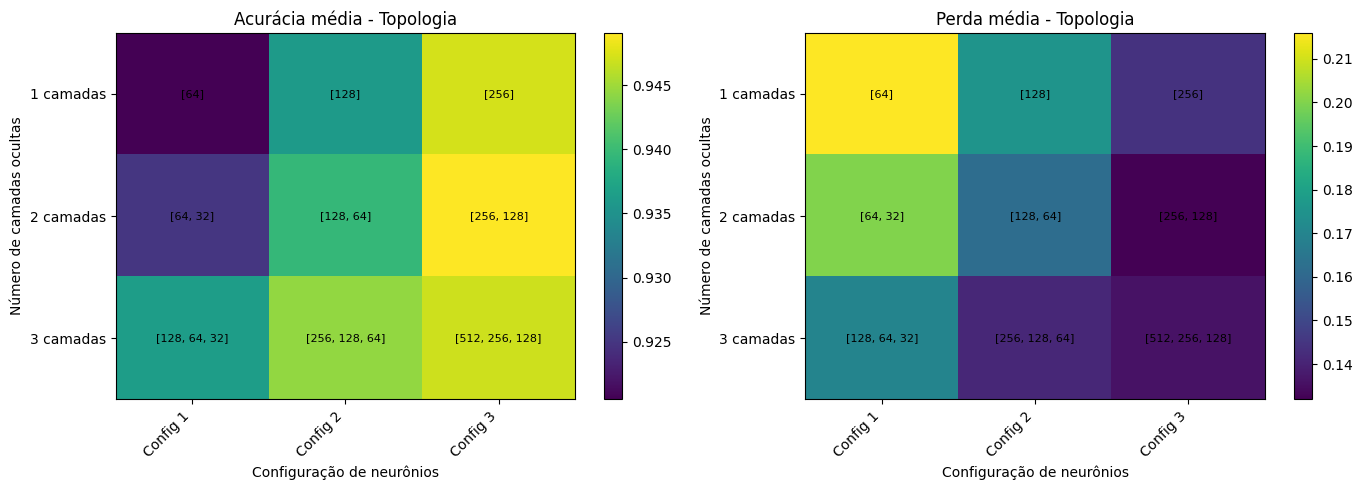

In [23]:
unique_num_hidden_layers = sorted(list({r['number of hidden layers'] for r in results_q3}))

# Para cada número de camadas, ordena as configurações de neurônios
# Como temos 3 opções por número de camadas, indexamos sequencialmente
configs_per_layers = {nh: [] for nh in unique_num_hidden_layers}
for r in results_q3:
    nh = r['number of hidden layers']
    nn = r['neurons per layer']
    if nn not in configs_per_layers[nh]:
        configs_per_layers[nh].append(nn)

# Ordena cada lista por tamanho crescente (total de neurônios)
for nh in configs_per_layers:
    configs_per_layers[nh].sort(key=lambda x: sum(x))

# Número máximo de configurações por número de camadas
max_configs = max(len(configs_per_layers[nh]) for nh in unique_num_hidden_layers)

# Matrizes para os mapas de calor
accuracy_matrix = np.full((len(unique_num_hidden_layers), max_configs), np.nan)
loss_matrix = np.full((len(unique_num_hidden_layers), max_configs), np.nan)


for i, nh in enumerate(unique_num_hidden_layers):
    for j, nn in enumerate(configs_per_layers[nh]):
        match = [r for r in results_q3 if r['number of hidden layers'] == nh and r['neurons per layer'] == nn]
        if match:
            accuracy_matrix[i, j] = match[0]['accuracy_mean']
            loss_matrix[i, j] = match[0]['loss_mean']

#Labels dos gráficos
col_labels = []
for nh in unique_num_hidden_layers:
    for nn in configs_per_layers[nh]:
        col_labels.append(str(nn))

config_labels = [f"Config {j+1}" for j in range(max_configs)]

# Visualização dos mapas de calor
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

im0 = axes[0].imshow(accuracy_matrix, cmap='viridis', aspect='auto')
axes[0].set_title('Acurácia média - Topologia')
axes[0].set_xticks(range(max_configs))
axes[0].set_xticklabels(config_labels, rotation=45, ha='right')
axes[0].set_yticks(range(len(unique_num_hidden_layers)))
axes[0].set_yticklabels([f"{nh} camadas" for nh in unique_num_hidden_layers])
axes[0].set_xlabel('Configuração de neurônios')
axes[0].set_ylabel('Número de camadas ocultas')

# Anota cada célula com a configuração real dentro do mapa
for i, nh in enumerate(unique_num_hidden_layers):
    for j, nn in enumerate(configs_per_layers[nh]):
        text = axes[0].text(j, i, str(nn), ha="center", va="center",
                           color="white" if accuracy_matrix[i, j] < 0.5 else "black",
                           fontsize=8)

plt.colorbar(im0, ax=axes[0])

im1 = axes[1].imshow(loss_matrix, cmap='viridis', aspect='auto')
axes[1].set_title('Perda média - Topologia')
axes[1].set_xticks(range(max_configs))
axes[1].set_xticklabels(config_labels, rotation=45, ha='right')
axes[1].set_yticks(range(len(unique_num_hidden_layers)))
axes[1].set_yticklabels([f"{nh} camadas" for nh in unique_num_hidden_layers])
axes[1].set_xlabel('Configuração de neurônios')
axes[1].set_ylabel('Número de camadas ocultas')

# Anota cada célula com a configuração real
for i, nh in enumerate(unique_num_hidden_layers):
    for j, nn in enumerate(configs_per_layers[nh]):
        text = axes[1].text(j, i, str(nn), ha="center", va="center",
                           color="white" if loss_matrix[i, j] > 0.5 else "black",
                           fontsize=8)

plt.colorbar(im1, ax=axes[1])

plt.tight_layout()
plt.show()


### Métricas

========== ANÁLISE DE TODAS AS TOPOLOGIAS Q3 ==========


2. CURVAS DE CONVERGÊNCIA - Separadas por número de camadas


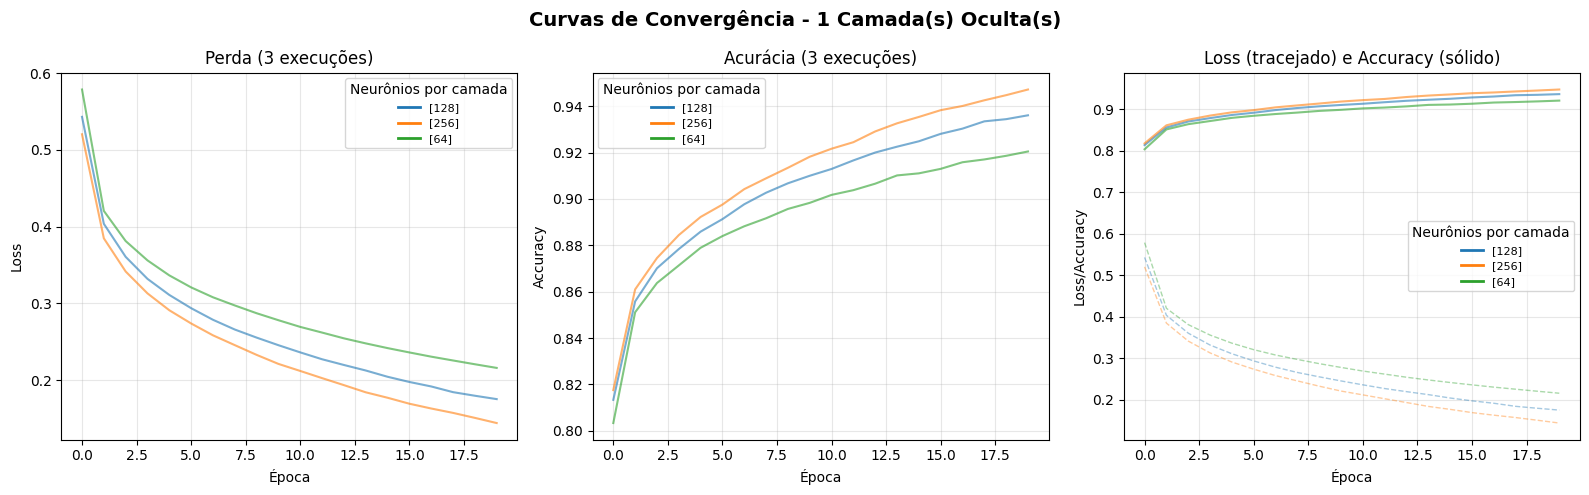


1 camada(s): 3 execuções
  Configuração [128]: 1 execução(ões)
  Configuração [256]: 1 execução(ões)
  Configuração [64]: 1 execução(ões)


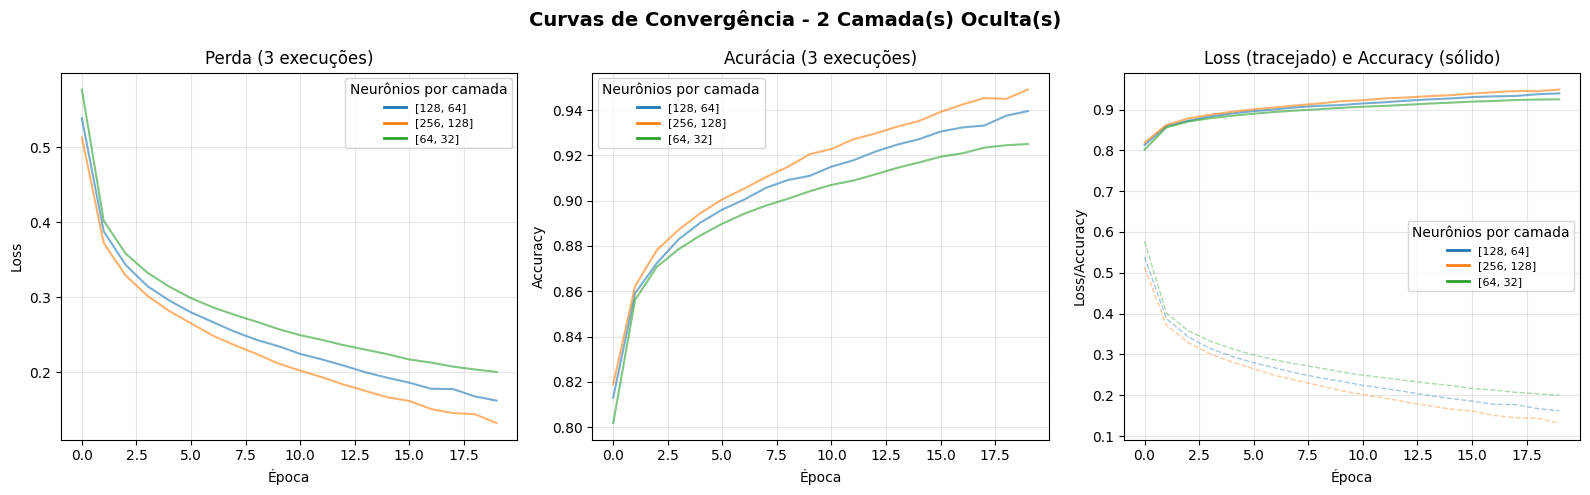


2 camada(s): 3 execuções
  Configuração [128, 64]: 1 execução(ões)
  Configuração [256, 128]: 1 execução(ões)
  Configuração [64, 32]: 1 execução(ões)


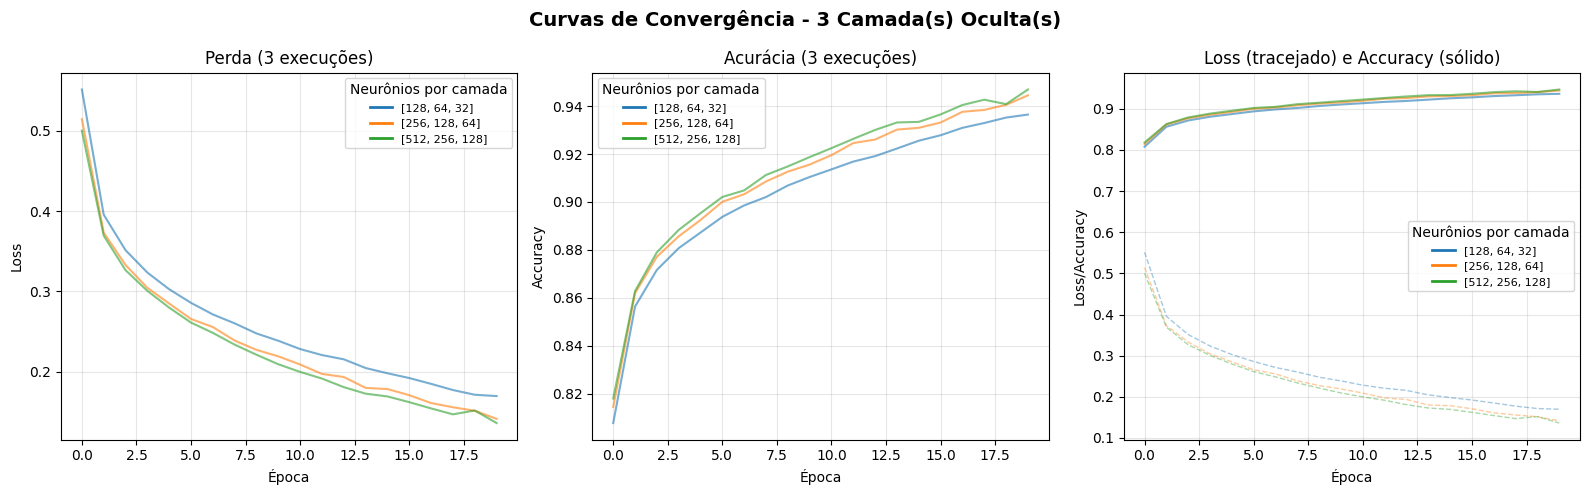


3 camada(s): 3 execuções
  Configuração [128, 64, 32]: 1 execução(ões)
  Configuração [256, 128, 64]: 1 execução(ões)
  Configuração [512, 256, 128]: 1 execução(ões)

2.5. CURVAS DE CONVERGÊNCIA - Todas as Topologias


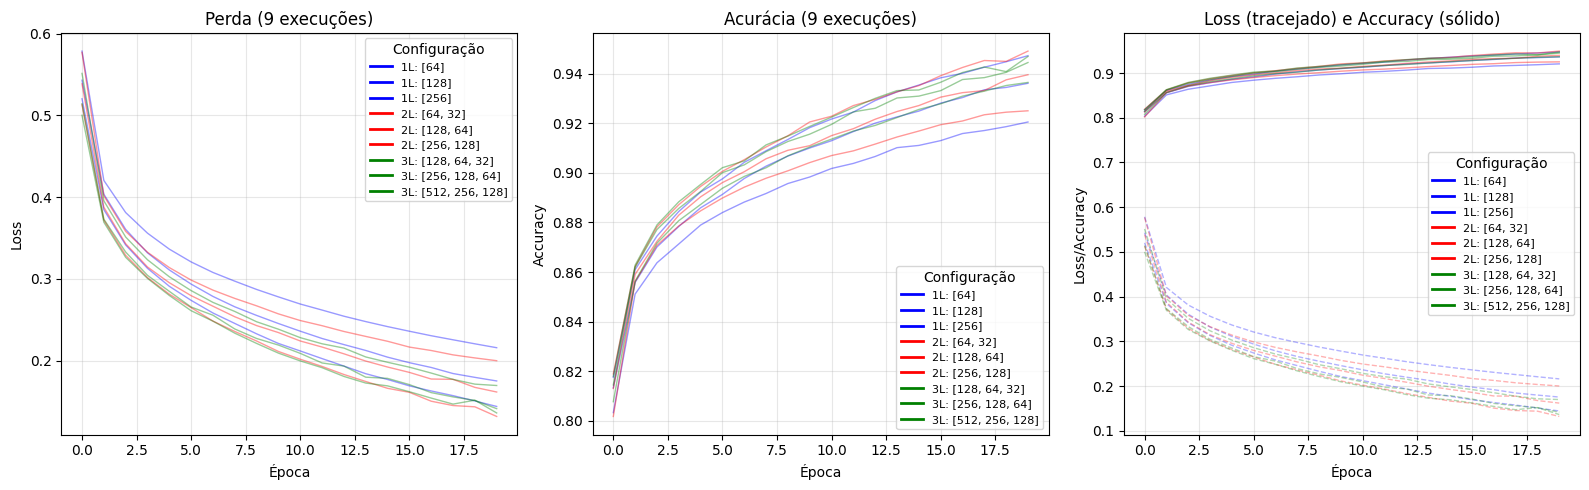


3. TEMPO DE TREINAMENTO


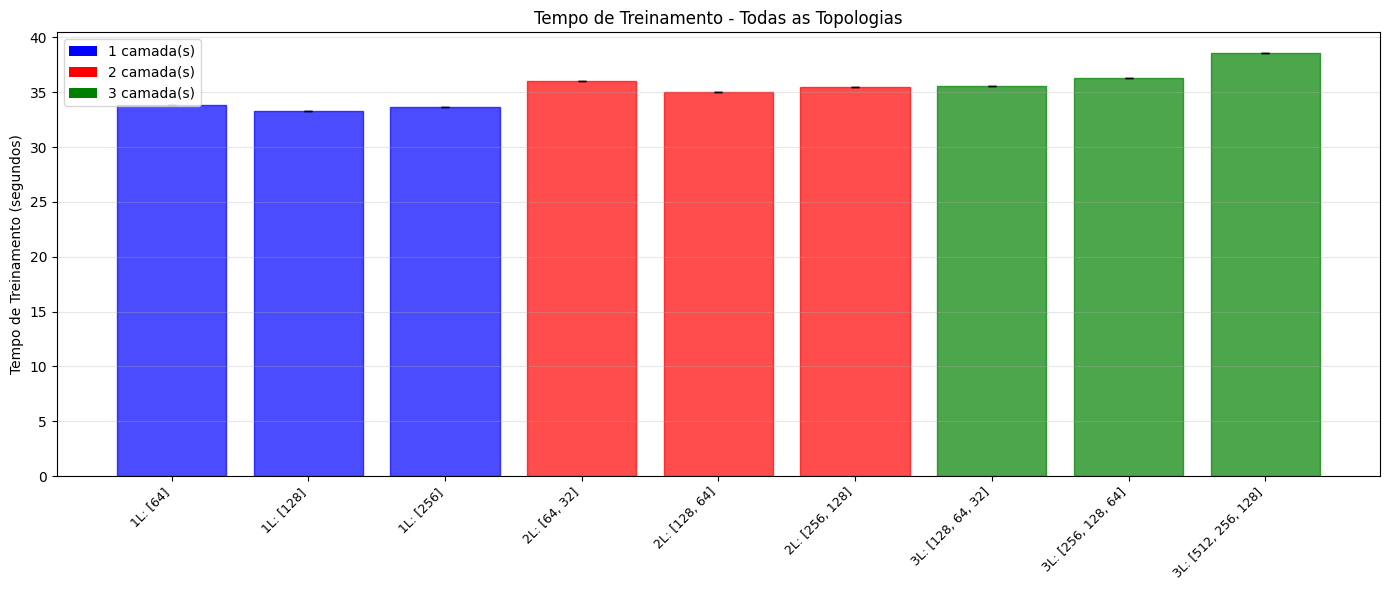


1 camada(s):
  [64]: Tempo = 33.87s (±0.00s)
  [128]: Tempo = 33.28s (±0.00s)
  [256]: Tempo = 33.67s (±0.00s)

2 camada(s):
  [64, 32]: Tempo = 36.07s (±0.00s)
  [128, 64]: Tempo = 35.06s (±0.00s)
  [256, 128]: Tempo = 35.45s (±0.00s)

3 camada(s):
  [128, 64, 32]: Tempo = 35.54s (±0.00s)
  [256, 128, 64]: Tempo = 36.31s (±0.00s)
  [512, 256, 128]: Tempo = 38.54s (±0.00s)

4. GENERALIZAÇÃO - Medida F1, Precisão e Revocação


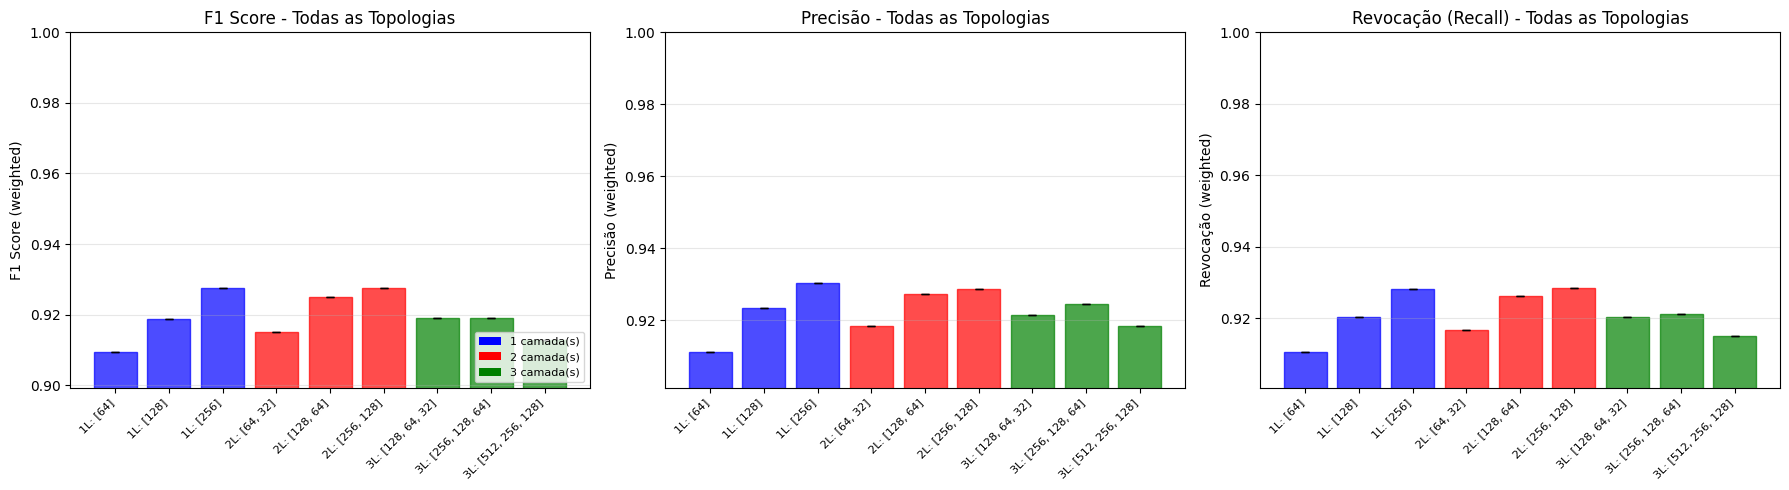

In [24]:
# Métricas da Questão 03: análise de todas as topologias testadas
# Métricas: função de perda, curva de convergência, tempo de treinamento, generalização (F1), precisão, revocação

print("========== ANÁLISE DE TODAS AS TOPOLOGIAS Q3 ==========\n")

# Organiza os resultados por número de camadas
results_by_layers = {}
for r in results_q3:
    nh = r['number of hidden layers']
    if nh not in results_by_layers:
        results_by_layers[nh] = []
    results_by_layers[nh].append(r)

# Ordena cada grupo por soma de neurônios
for nh in results_by_layers:
    results_by_layers[nh].sort(key=lambda x: sum(x['neurons per layer']))

colors_map = {1: 'blue', 2: 'red', 3: 'green'}
markers_map = {1: 'o', 2: 's', 3: '^'}

# Prepara dados agregados
all_configs = []
all_losses = []
all_loss_stds = []
all_accuracies = []
all_acc_stds = []
all_times = []
all_time_stds = []
all_f1 = []
all_f1_stds = []
all_precision = []
all_precision_stds = []
all_recall = []
all_recall_stds = []
colors_list = []

for nh in sorted(results_by_layers.keys()):
    for r in results_by_layers[nh]:
        config_label = f"{nh}L: {r['neurons per layer']}"
        all_configs.append(config_label)
        all_losses.append(r['loss_mean'])
        all_loss_stds.append(r['loss_std'])
        all_accuracies.append(r['accuracy_mean'])
        all_acc_stds.append(r['accuracy_std'])
        all_times.append(r['time_mean'])
        all_time_stds.append(r['time_std'])
        all_f1.append(r['f1_mean'])
        all_f1_stds.append(r['f1_std'])
        all_precision.append(r['precision_mean'])
        all_precision_stds.append(r['precision_std'])
        all_recall.append(r['recall_mean'])
        all_recall_stds.append(r['recall_std'])
        colors_list.append(colors_map[nh])

x_pos = np.arange(len(all_configs))

# Legenda comum
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=colors_map[nh], label=f'{nh} camada(s)')
                   for nh in sorted(colors_map.keys())]

# ========== 2. CURVAS DE CONVERGÊNCIA - POR NÚMERO DE CAMADAS ==========
print("\n2. CURVAS DE CONVERGÊNCIA - Separadas por número de camadas")

# Define cores distintas para cada configuração de neurônios
colors_neurons = plt.cm.tab10(np.linspace(0, 1, 10))

# Para cada número de camadas, cria um conjunto de 3 subplots
for num_layers in sorted(set([h['num_hidden_layers'] for h in histories_q3])):
    # Filtra históricos desta configuração de camadas
    layer_histories = [h for h in histories_q3 if h['num_hidden_layers'] == num_layers]

    # Organiza por configuração única de neurônios
    unique_configs = {}
    for h in layer_histories:
        config_key = str(h['neurons_per_layer'])
        if config_key not in unique_configs:
            unique_configs[config_key] = []
        unique_configs[config_key].append(h['history'])

    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    fig.suptitle(f'Curvas de Convergência - {num_layers} Camada(s) Oculta(s)', fontsize=14, fontweight='bold')


    axes[0].set_title(f'Perda ({len(layer_histories)} execuções)')
    color_idx = 0
    for config_key, histories_list in sorted(unique_configs.items()):
        color = colors_neurons[color_idx % len(colors_neurons)]
        for h in histories_list:
            axes[0].plot(h.history['loss'], alpha=0.6, linewidth=1.5, color=color)
        # Adiciona label apenas uma vez por configuração
        axes[0].plot([], [], color=color, linewidth=2, label=config_key)
        color_idx += 1

    axes[0].set_xlabel('Época')
    axes[0].set_ylabel('Loss')
    axes[0].legend(title='Neurônios por camada', fontsize=8, loc='best')
    axes[0].grid(True, alpha=0.3)


    axes[1].set_title(f'Acurácia ({len(layer_histories)} execuções)')
    color_idx = 0
    for config_key, histories_list in sorted(unique_configs.items()):
        color = colors_neurons[color_idx % len(colors_neurons)]
        for h in histories_list:
            axes[1].plot(h.history['accuracy'], alpha=0.6, linewidth=1.5, color=color)
        # Adiciona label apenas uma vez por configuração
        axes[1].plot([], [], color=color, linewidth=2, label=config_key)
        color_idx += 1

    axes[1].set_xlabel('Época')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend(title='Neurônios por camada', fontsize=8, loc='best')
    axes[1].grid(True, alpha=0.3)


    axes[2].set_title('Loss (tracejado) e Accuracy (sólido)')
    color_idx = 0
    for config_key, histories_list in sorted(unique_configs.items()):
        color = colors_neurons[color_idx % len(colors_neurons)]
        for h in histories_list:
            axes[2].plot(h.history['loss'], alpha=0.4, linewidth=1, color=color, linestyle='--')
            axes[2].plot(h.history['accuracy'], alpha=0.6, linewidth=1.5, color=color)
        # Adiciona labels
        axes[2].plot([], [], color=color, linewidth=2, label=config_key)
        color_idx += 1

    axes[2].set_xlabel('Época')
    axes[2].set_ylabel('Loss/Accuracy')
    axes[2].legend(title='Neurônios por camada', fontsize=8, loc='best')
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print(f"\n{num_layers} camada(s): {len(layer_histories)} execuções")
    for config_key in sorted(unique_configs.keys()):
        print(f"  Configuração {config_key}: {len(unique_configs[config_key])} execução(ões)")

print("\n2.5. CURVAS DE CONVERGÊNCIA - Todas as Topologias")
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
# Perda
for r in results_q3:
    config_key = f"{r['number of hidden layers']}L: {r['neurons per layer']}"
    color = colors_map[r['number of hidden layers']]
    matching_histories = [h for h in histories_q3 if h['num_hidden_layers'] == r['number of hidden layers'] and h['neurons_per_layer'] == r['neurons per layer']]
    for h in matching_histories:
        axes[0].plot(h['history'].history['loss'], alpha=0.4, linewidth=1, color=color)
    axes[0].plot([], [], color=color, linewidth=2, label=config_key)
axes[0].set_title(f'Perda ({len(histories_q3)} execuções)')
axes[0].set_xlabel('Época')
axes[0].set_ylabel('Loss')
axes[0].legend(title='Configuração', fontsize=8, loc='best')
axes[0].grid(True, alpha=0.3)
# Acurácia
for r in results_q3:
    config_key = f"{r['number of hidden layers']}L: {r['neurons per layer']}"
    color = colors_map[r['number of hidden layers']]
    matching_histories = [h for h in histories_q3 if h['num_hidden_layers'] == r['number of hidden layers'] and h['neurons_per_layer'] == r['neurons per layer']]
    for h in matching_histories:
        axes[1].plot(h['history'].history['accuracy'], alpha=0.4, linewidth=1, color=color)
    axes[1].plot([], [], color=color, linewidth=2, label=config_key)
axes[1].set_title(f'Acurácia ({len(histories_q3)} execuções)')
axes[1].set_xlabel('Época')
axes[1].set_ylabel('Accuracy')
axes[1].legend(title='Configuração', fontsize=8, loc='best')
axes[1].grid(True, alpha=0.3)
# Ambas
for r in results_q3:
    config_key = f"{r['number of hidden layers']}L: {r['neurons per layer']}"
    color = colors_map[r['number of hidden layers']]
    matching_histories = [h for h in histories_q3 if h['num_hidden_layers'] == r['number of hidden layers'] and h['neurons_per_layer'] == r['neurons per layer']]
    for h in matching_histories:
        axes[2].plot(h['history'].history['loss'], alpha=0.3, linewidth=1, color=color, linestyle='--')
        axes[2].plot(h['history'].history['accuracy'], alpha=0.4, linewidth=1, color=color)
    axes[2].plot([], [], color=color, linewidth=2, label=config_key)
axes[2].set_title('Loss (tracejado) e Accuracy (sólido)')
axes[2].set_xlabel('Época')
axes[2].set_ylabel('Loss/Accuracy')
axes[2].legend(title='Configuração', fontsize=8, loc='best')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ========== 3. TEMPO DE TREINAMENTO ==========
print("\n3. TEMPO DE TREINAMENTO")
fig, ax = plt.subplots(figsize=(14, 6))

bars = ax.bar(x_pos, all_times, yerr=all_time_stds, alpha=0.7, capsize=3)
for i, bar in enumerate(bars):
    bar.set_color(colors_list[i])

ax.set_xticks(x_pos)
ax.set_xticklabels(all_configs, rotation=45, ha='right', fontsize=9)
ax.set_ylabel('Tempo de Treinamento (segundos)')
ax.set_title('Tempo de Treinamento - Todas as Topologias')
ax.grid(True, alpha=0.3, axis='y')
ax.legend(handles=legend_elements, loc='upper left')

plt.tight_layout()
plt.show()

for nh in sorted(results_by_layers.keys()):
    print(f"\n{nh} camada(s):")
    for r in results_by_layers[nh]:
        print(f"  {r['neurons per layer']}: Tempo = {r['time_mean']:.2f}s (±{r['time_std']:.2f}s)")

# ========== 4. GENERALIZAÇÃO (F1, PRECISÃO, REVOCAÇÃO) ==========
print("\n4. GENERALIZAÇÃO - Medida F1, Precisão e Revocação")
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# F1 Score
bars0 = axes[0].bar(x_pos, all_f1, yerr=all_f1_stds, alpha=0.7, capsize=3)
for i, bar in enumerate(bars0):
    bar.set_color(colors_list[i])
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(all_configs, rotation=45, ha='right', fontsize=8)
axes[0].set_ylabel('F1 Score (weighted)')
axes[0].set_title('F1 Score - Todas as Topologias')
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].set_ylim([min(all_f1) - 0.01, 1.0])
axes[0].legend(handles=legend_elements, loc='lower right', fontsize=8)

# Precisão
bars1 = axes[1].bar(x_pos, all_precision, yerr=all_precision_stds, alpha=0.7, capsize=3)
for i, bar in enumerate(bars1):
    bar.set_color(colors_list[i])
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(all_configs, rotation=45, ha='right', fontsize=8)
axes[1].set_ylabel('Precisão (weighted)')
axes[1].set_title('Precisão - Todas as Topologias')
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].set_ylim([min(all_precision) - 0.01, 1.0])

# Revocação
bars2 = axes[2].bar(x_pos, all_recall, yerr=all_recall_stds, alpha=0.7, capsize=3)
for i, bar in enumerate(bars2):
    bar.set_color(colors_list[i])
axes[2].set_xticks(x_pos)
axes[2].set_xticklabels(all_configs, rotation=45, ha='right', fontsize=8)
axes[2].set_ylabel('Revocação (weighted)')
axes[2].set_title('Revocação (Recall) - Todas as Topologias')
axes[2].grid(True, alpha=0.3, axis='y')
axes[2].set_ylim([min(all_recall) - 0.01, 1.0])

plt.tight_layout()
plt.show()


In [25]:
from sklearn.metrics import classification_report
import time
import matplotlib.pyplot as plt

def treinar_avaliar_modelo(config, x_train, y_train, x_val, y_val, x_test=None, y_test=None, verbose=0):
    # 1. Configura seed e modelo
    keras.utils.set_random_seed(42)

    # Extrai configs ou usa padrões
    lr = config.get('learning_rate', 0.001)
    beta1 = config.get('beta1', 0.7)
    layers = config.get('layers', 2)
    neurons = config.get('neurons', [256, 128])
    epochs = config.get('epochs', 50)
    batch_size = config.get('batch_size', 64)
    activation_hidden = config.get('activation_hidden', 'relu')

    model = build_model(learning_rate=lr, beta1=beta1,
                        num_hidden_layers=layers, neurons_per_layer=neurons,
                        activation_hidden=activation_hidden)

    # 2. Callback Padrão
    es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # 3. Treino
    start = time.time()
    history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size,
                        validation_data=(x_val, y_val), callbacks=[es], verbose=verbose)
    tempo = time.time() - start

    # 4. Métricas finais
    results = {
        'history': history,
        'time': tempo,
        'epochs_run': len(history.history['loss']),
        'train_loss': history.history['loss'][-1],
        'val_loss': min(history.history['val_loss']),
        'val_acc': max(history.history['val_accuracy'])
    }

    # Predição para F1 score, precisão, recall no conjunto de validação
    y_val_pred_prob = model.predict(x_val, verbose=0)
    y_val_pred = np.argmax(y_val_pred_prob, axis=1)
    report_val = classification_report(y_val, y_val_pred, output_dict=True, zero_division=0)
    results.update({
        'val_f1': report_val['weighted avg']['f1-score'],
        'val_precision': report_val['weighted avg']['precision'],
        'val_recall': report_val['weighted avg']['recall'],
    })

    # 5. Avaliação no teste (usado na Q5 e Q6)
    if x_test is not None:
        y_pred = np.argmax(model.predict(x_test, verbose=0), axis=1)
        report_test = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
        results.update({
            'test_acc': report_test['accuracy'],
            'test_f1': report_test['weighted avg']['f1-score'],
            'test_precision': report_test['weighted avg']['precision'],
            'test_recall': report_test['weighted avg']['recall'],
            'test_loss': model.evaluate(x_test, y_test, verbose=0)[0]
        })

    return results

In [26]:
def plotar_curvas(histories, titulos):
    """Plota Loss e Acurácia para uma lista de históricos."""
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))

    if not isinstance(histories, list): histories = [histories]
    if not isinstance(titulos, list): titulos = [titulos]

    for h, titulo in zip(histories, titulos):
        dados = h.history if hasattr(h, 'history') else h
        # Loss
        ax[0].plot(dados['loss'], label=f'{titulo} (Treino)')
        if 'val_loss' in dados:
            ax[0].plot(dados['val_loss'], linestyle='--', label=f'{titulo} (Val)')
        # Acurácia
        ax[1].plot(dados['accuracy'], label=f'{titulo} (Treino)')
        if 'val_accuracy' in dados:
            ax[1].plot(dados['val_accuracy'], linestyle='--', label=f'{titulo} (Val)')

    ax[0].set_title('Perda (Loss)'); ax[0].legend(); ax[0].grid(True, alpha=0.3)
    ax[1].set_title('Acurácia'); ax[1].legend(); ax[1].grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Questão 04
melhor modelo até o momento(desconsiderando velocidade de convergência):
- 2 camadas ocultas, com 256 e 128 neurônios
- batch size: 64
- beta1: 0.7
- learning rate: 0.001
- epochs: 20
- função de ativação: tanh

=== INICIANDO QUESTÃO 4 ===
Topologia Fixa: 2 camadas ocultas [256, 128]
Hiperparâmetros: LR=0.001, Beta1=0.7, Epochs=20, Batch=64
Testando frações: [0.1, 0.3, 0.5, 0.7, 1.0]

> Treinando com 10% dos dados (4800 amostras)...
  Tempo: 11.5s | Val Acc: 0.8473 | Val Loss: 0.4656
> Treinando com 30% dos dados (14400 amostras)...
  Tempo: 14.6s | Val Acc: 0.8785 | Val Loss: 0.3570
> Treinando com 50% dos dados (24000 amostras)...
  Tempo: 19.5s | Val Acc: 0.8806 | Val Loss: 0.3385
> Treinando com 70% dos dados (33600 amostras)...
  Tempo: 23.4s | Val Acc: 0.8802 | Val Loss: 0.3427
> Treinando com 100% dos dados (48000 amostras)...
  Tempo: 36.6s | Val Acc: 0.8872 | Val Loss: 0.3594


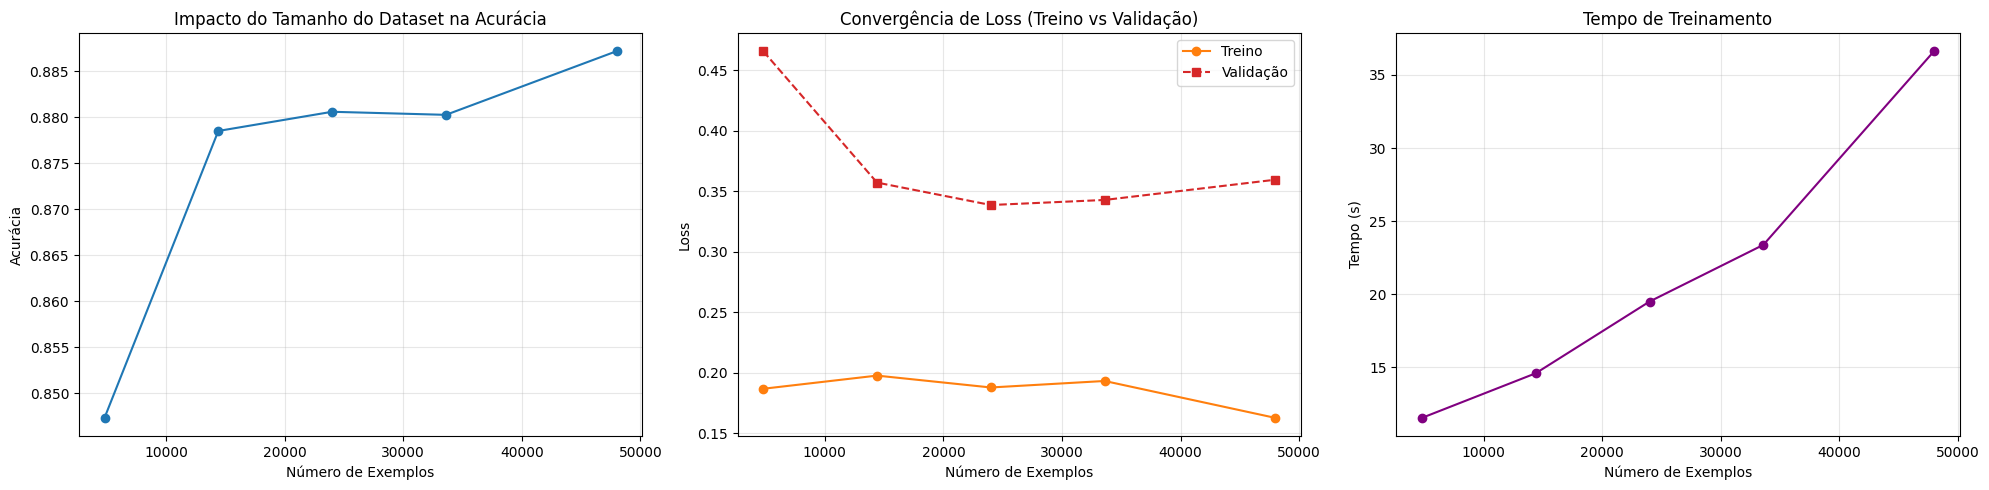


RESUMO DOS RESULTADOS (QUESTÃO 4):
Dados(%)   | Amostras   | Tempo(s)   | Val Acc    | Val F1    
-----------------------------------------------------------------
10         | 4800       | 11.54      | 0.8473     | 0.8393    
30         | 14400      | 14.60      | 0.8785     | 0.8746    
50         | 24000      | 19.50      | 0.8806     | 0.8799    
70         | 33600      | 23.38      | 0.8802     | 0.8810    
100        | 48000      | 36.62      | 0.8872     | 0.8818    


In [27]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import time
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras

# ==============================================================================
# CONFIGURAÇÃO DA MELHOR TOPOLOGIA (Da Questão 3)
# ==============================================================================
MELHOR_NUM_CAMADAS = 2
MELHOR_NEURONIOS = [256, 128]
MELHOR_LR = 0.001       # Valor que obteve bom desempenho (Loss ~0.13)
MELHOR_BETA1 = 0.7
EPOCHS_FIXAS = 20
BATCH_SIZE_FIXO = 64

# ==============================================================================
# QUESTÃO 04: Influência da Quantidade de Dados
# ==============================================================================

# Frações do dataset para teste (10% a 100%)
fractions = [0.1, 0.3, 0.5, 0.7, 1.0]
results_q4 = []

print(f"=== INICIANDO QUESTÃO 4 ===")
print(f"Topologia Fixa: {MELHOR_NUM_CAMADAS} camadas ocultas {MELHOR_NEURONIOS}")
print(f"Hiperparâmetros: LR={MELHOR_LR}, Beta1={MELHOR_BETA1}, Epochs={EPOCHS_FIXAS}, Batch={BATCH_SIZE_FIXO}")
print(f"Testando frações: {fractions}\n")

for frac in fractions:
    # 1. Amostragem estratificada
    if frac == 1.0:
        x_subset, y_subset = x_train, y_train
    else:
        # Mantem a proporção das classes mesmo cortando os dados
        x_subset, _, y_subset, _ = train_test_split(
            x_train, y_train,
            train_size=frac,
            stratify=y_train,
            random_state=42
        )

    n_samples = len(x_subset)
    print(f"> Treinando com {int(frac * 100)}% dos dados ({n_samples} amostras)...")

    # 2. Configurações para a função treinar_avaliar_modelo
    config_q4 = {
        'learning_rate': MELHOR_LR,
        'beta1': MELHOR_BETA1,
        'layers': MELHOR_NUM_CAMADAS,
        'neurons': MELHOR_NEURONIOS,
        'epochs': EPOCHS_FIXAS, # Passa o número de épocas da Q4
        'batch_size': BATCH_SIZE_FIXO # Passa o batch size da Q4
    }

    # 3. Treinar e avaliar o modelo usando a função utilitária
    # Passa x_test e y_test para que a função já calcule as métricas de teste
    metrics = treinar_avaliar_modelo(config_q4, x_subset, y_subset, x_val, y_val, x_test=x_test, y_test=y_test, verbose=0)

    # 4. Coleta métricas do resultado
    results_q4.append({
        'fraction': frac,
        'samples': n_samples,
        'time': metrics['time'],
        'train_loss': metrics['train_loss'],
        'val_loss': metrics['val_loss'],
        'val_acc': metrics['val_acc'],
        'val_f1': metrics['val_f1'],
        'test_acc': metrics['test_acc']
    })

    print(f"  Tempo: {metrics['time']:.1f}s | Val Acc: {metrics['val_acc']:.4f} | Val Loss: {metrics['val_loss']:.4f}")


# ==============================================================================
# VISUALIZAÇÃO DOS RESULTADOS
# ==============================================================================

sizes = [r['samples'] for r in results_q4]
val_accs = [r['val_acc'] for r in results_q4]
train_losses = [r['train_loss'] for r in results_q4]
val_losses = [r['val_loss'] for r in results_q4]
times = [r['time'] for r in results_q4]

fig, ax = plt.subplots(1, 3, figsize=(20, 5))

# 1. Curva de aprendizado
ax[0].plot(sizes, val_accs, 'o-', label='Validação', color='tab:blue')
ax[0].set_title('Impacto do Tamanho do Dataset na Acurácia')
ax[0].set_xlabel('Número de Exemplos')
ax[0].set_ylabel('Acurácia')
ax[0].grid(True, alpha=0.3)

# 2. Curva de loss (treino vs validação) - identifica overfitting em poucos dados
ax[1].plot(sizes, train_losses, 'o-', label='Treino', color='tab:orange')
ax[1].plot(sizes, val_losses, 's--', label='Validação', color='tab:red')
ax[1].set_title('Convergência de Loss (Treino vs Validação)')
ax[1].set_xlabel('Número de Exemplos')
ax[1].set_ylabel('Loss')
ax[1].legend()
ax[1].grid(True, alpha=0.3)

# 3. Custo computacional
ax[2].plot(sizes, times, 'o-', color='purple')
ax[2].set_title('Tempo de Treinamento')
ax[2].set_xlabel('Número de Exemplos')
ax[2].set_ylabel('Tempo (s)')
ax[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Tabela final
print("\nRESUMO DOS RESULTADOS (QUESTÃO 4):")
print(f"{'Dados(%)':<10} | {'Amostras':<10} | {'Tempo(s)':<10} | {'Val Acc':<10} | {'Val F1':<10}")
print("-" * 65)
for r in results_q4:
    print(f"{r['fraction']*100:<10.0f} | {r['samples']:<10} | {r['time']:<10.2f} | {r['val_acc']:<10.4f} | {r['val_f1']:<10.4f}")

In [28]:
# Questão 5

>>> Separando 4 melhores modelos da memória.
   [1º Lugar] Selecionado: Modelo A (2L: 256,128) | Acurácia Q3: 0.9491
   [2º Lugar] Selecionado: Modelo B (1L: 256) | Acurácia Q3: 0.9472
   [3º Lugar] Selecionado: Modelo C (3L: 512,256,128) | Acurácia Q3: 0.9469
   [4º Lugar] Selecionado: Modelo D (3L: 256,128,64) | Acurácia Q3: 0.9445


=== INICIANDO QUESTÃO 5: Treinamento Final e Teste ===
Usando 100% dos dados de treino (48000 amostras)
Estratégia: Early Stopping (paciência=5 épocas)

> Treinando Modelo A (2L: 256,128)...
  Terminou em 16 épocas (37.4s)
  Teste Acc: 0.8760 | F1: 0.8762

> Treinando Modelo B (1L: 256)...
  Terminou em 17 épocas (39.5s)
  Teste Acc: 0.8799 | F1: 0.8805

> Treinando Modelo C (3L: 512,256,128)...
  Terminou em 13 épocas (31.1s)
  Teste Acc: 0.8763 | F1: 0.8766

> Treinando Modelo D (3L: 256,128,64)...
  Terminou em 12 épocas (28.7s)
  Teste Acc: 0.8718 | F1: 0.8719


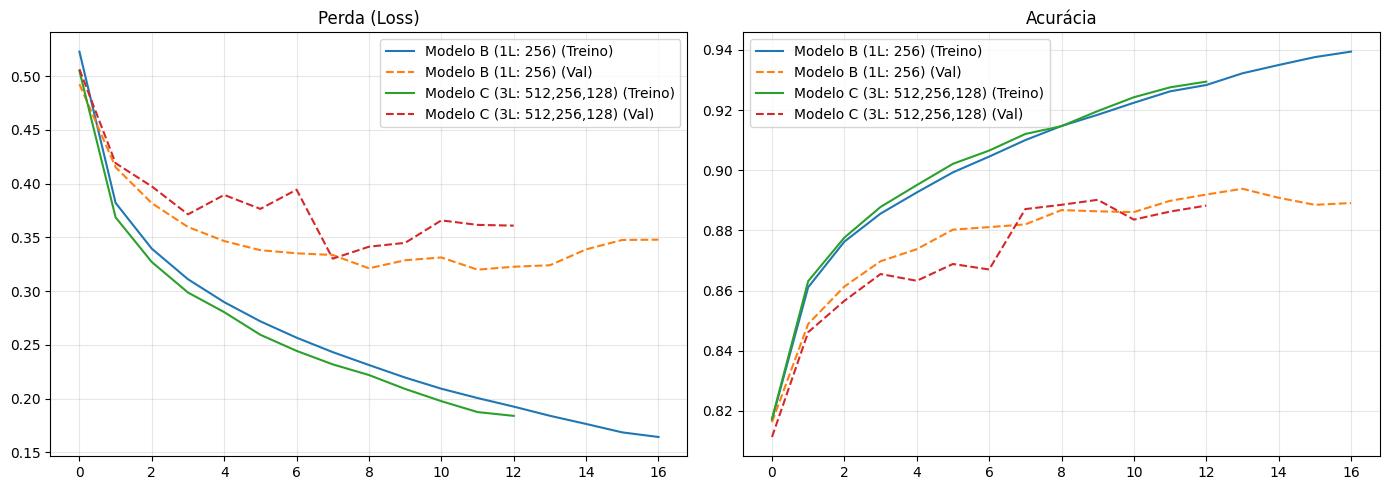


MODELO                    | ACC (Teste)  | F1 (Teste)   | Épocas   | Tempo   
Modelo B (1L: 256)        | 0.8799       | 0.8805       | 17       | 39.5s
Modelo C (3L: 512,256,128) | 0.8763       | 0.8766       | 13       | 31.1s
Modelo A (2L: 256,128)    | 0.8760       | 0.8762       | 16       | 37.4s
Modelo D (3L: 256,128,64) | 0.8718       | 0.8719       | 12       | 28.7s

>>> RESULTADO: O modelo 'Modelo B (1L: 256)' parece ser a melhor escolha para a Q6.


In [29]:
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import EarlyStopping
import sys

# ==============================================================================
# CONFIGURAÇÃO DA QUESTÃO 5
# ==============================================================================

# Recupera as 4 melhores topologias da Questão 3
top_4_configs = []

# Verifica se a lista de resultados existe
if 'sorted_results_q3' in globals() and len(sorted_results_q3) > 0:
    print(f">>> Separando {min(4, len(sorted_results_q3))} melhores modelos da memória.")

    # Os 4 melhores resultados
    for i, res in enumerate(sorted_results_q3[:4]):

        # Prepara os dados para o formato que a Questão 5 espera
        n_layers = res['number of hidden layers']
        neurons_list = res['neurons per layer']

        # Gera o nome do modelo. ("Modelo A (2L: 256,128)")
        neurons_str = ",".join(str(n) for n in neurons_list)
        model_name = f"Modelo {chr(65+i)} ({n_layers}L: {neurons_str})"

        # Dicionário de configuração
        config = {
            'layers': n_layers,
            'neurons': neurons_list,
            'name': model_name
        }
        top_4_configs.append(config)

        # Feedback visual para confirmar quais modelos foram pegos
        print(f"   [{i+1}º Lugar] Selecionado: {model_name} | Acurácia Q3: {res.get('accuracy_mean', 0):.4f}")

elif 'top_4_configs' not in globals() or not top_4_configs:
    # Fallback apenas se a célula anterior não tiver sido rodada ou top_4_configs estiver vazia
    print(">>> AVISO: 'sorted_results_q3' não encontrado ou vazio. Usando configurações de fallback.")
    top_4_configs = [
        {'layers': 2, 'neurons': [256, 128], 'name': 'Modelo A (Fallback 2L: 256,128)'},
        {'layers': 1, 'neurons': [256], 'name': 'Modelo B (Fallback 1L: 256)'},
        {'layers': 3, 'neurons': [512, 256, 128], 'name': 'Modelo C (Fallback 3L: 512,256,128)'},
        {'layers': 3, 'neurons': [256, 128, 64], 'name': 'Modelo D (Fallback 3L: 256,128,64)'}
    ]
    print("   Usando configurações de fallback.")


# Melhores parâmetros fixos
LR_FINAL = 0.001       # Da Q2
BETA1_FINAL = 0.7      # Da Q2
MAX_EPOCHS = 50        # 50 é alto, mas o Early Stopping corta antes
BATCH_SIZE_FINAL = 64  # Da Q2

print(f"\n\n=== INICIANDO QUESTÃO 5: Treinamento Final e Teste ===")
print(f"Usando 100% dos dados de treino ({len(x_train)} amostras)")
print(f"Estratégia: Early Stopping (paciência=5 épocas)")

final_results = []
histories_q5 = []

for config in top_4_configs:
    print(f"\n> Treinando {config['name']}...")

    # 1. Configurações para a função treinar_avaliar_modelo
    current_model_config = {
        'learning_rate': LR_FINAL,
        'beta1': BETA1_FINAL,
        'layers': config['layers'],
        'neurons': config['neurons'],
        'epochs': MAX_EPOCHS,
        'batch_size': BATCH_SIZE_FINAL
    }

    # 2. Treinar e avaliar o modelo usando a função utilitária
    # treinar_avaliar_modelo já implementa EarlyStopping e avaliação no test set
    metrics = treinar_avaliar_modelo(current_model_config, x_train, y_train, x_val, y_val, x_test=x_test, y_test=y_test, verbose=0)

    # Salva resultados
    res = {
        'name': config['name'],
        'config': current_model_config,
        'time': metrics['time'],
        'epochs_run': metrics['epochs_run'],
        'test_acc': metrics['test_acc'],
        'test_f1': metrics['test_f1'],
        'test_precision': metrics['test_precision'],
        'test_recall': metrics['test_recall'],
        'val_loss_final': metrics['val_loss'],
        'history': metrics['history']
    }
    final_results.append(res)
    histories_q5.append(metrics['history'])

    print(f"  Terminou em {res['epochs_run']} épocas ({res['time']:.1f}s)")
    print(f"  Teste Acc: {res['test_acc']:.4f} | F1: {res['test_f1']:.4f}")

# ==============================================================================
# ANÁLISE E VISUALIZAÇÃO
# ==============================================================================

# Gráfico das curvas de aprendizado dos dois melhores modelos
best_2 = sorted(final_results, key=lambda x: x['test_acc'], reverse=True)[:2]
plotar_curvas([m['history'] for m in best_2], [m['name'] for m in best_2])

# Tabela final de decisão
print("\n" + "="*100)
print(f"{'MODELO':<25} | {'ACC (Teste)':<12} | {'F1 (Teste)':<12} | {'Épocas':<8} | {'Tempo':<8}")
print("="*100)
# Ordena por F1 Score no teste (critério de desempate comum)
final_results.sort(key=lambda x: x['test_f1'], reverse=True)

for r in final_results:
    print(f"{r['name']:<25} | {r['test_acc']:.4f}       | {r['test_f1']:.4f}       | {r['epochs_run']:<8} | {r['time']:.1f}s")
print("="*100)

print(f"\n>>> RESULTADO: O modelo '{final_results[0]['name']}' parece ser a melhor escolha para a Q6.")

In [30]:
# Questão 6

=== INICIANDO QUESTÃO 6: Validação Cruzada (K=5) ===
Modelo Avaliado: Modelo B (1L: 256) - Vencedor Q5
Total de dados para rodízio: 60000 amostras

> Rodando Fold 1/5...
   -> Fold 1 Acc: 87.62% | Loss: 0.3551

> Rodando Fold 2/5...
   -> Fold 2 Acc: 87.88% | Loss: 0.3323

> Rodando Fold 3/5...
   -> Fold 3 Acc: 89.08% | Loss: 0.3149

> Rodando Fold 4/5...
   -> Fold 4 Acc: 87.86% | Loss: 0.3422

> Rodando Fold 5/5...
   -> Fold 5 Acc: 89.26% | Loss: 0.3165

RELATÓRIO FINAL - VALIDAÇÃO CRUZADA K-FOLD
Modelo: Modelo B (1L: 256) - Vencedor Q5
Média de Acurácia: 88.34% (+/- 0.69%)
Média de Perda:    0.3322
------------------------------------------------------------
Detalhamento por Fold:
  Fold 1: 87.62%
  Fold 2: 87.88%
  Fold 3: 89.08%
  Fold 4: 87.86%
  Fold 5: 89.26%


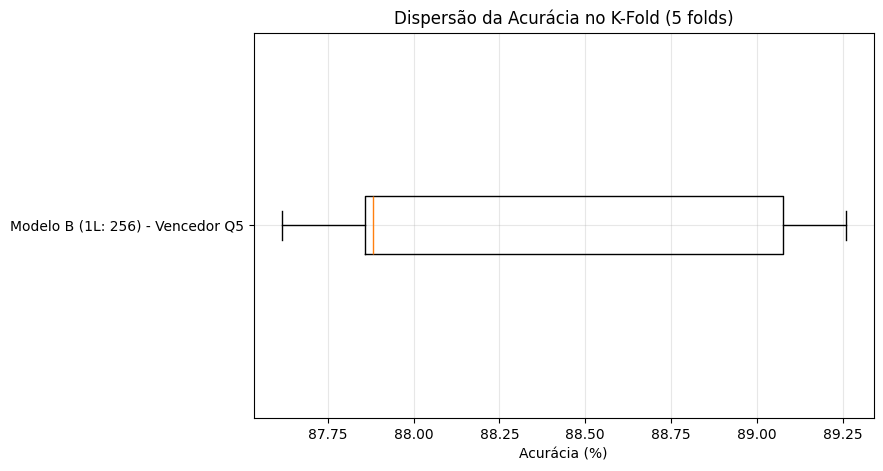

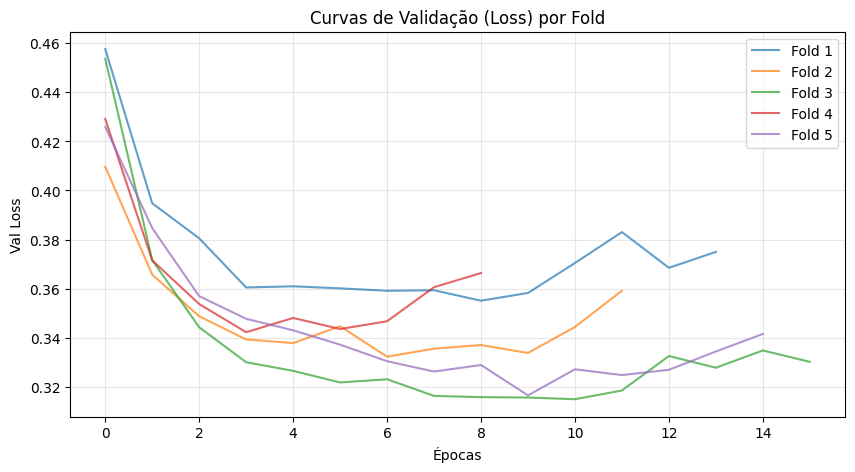


>>> CONCLUSÃO Q6: O modelo é robusto (std=0.69% < 1.5%).
O desempenho se manteve estável em diferentes subconjuntos de dados,
 confirmando que a escolha da Questão 5 é válida, e não por acaso.


In [32]:
from sklearn.model_selection import KFold
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping

# ==============================================================================
# QUESTÃO 06: VALIDAÇÃO CRUZADA K-FOLD
# ==============================================================================
# Divisão do dataset em k-subconjuntos e teste em todos eles.

# --- Configuração ---
# melhor configuração da Q5 (Modelo A 2L: 256,128)
BEST_CONFIG_Q6 = {
    'layers': 1,
    'neurons': [256],
    'name': 'Modelo B (1L: 256) - Vencedor Q5'
}

# Parâmetros de treino
K_FOLDS = 5
BATCH_SIZE = 64
MAX_EPOCHS = 50
LR_FINAL = 0.001     # Melhor Learning Rate da Q2
BETA1_FINAL = 0.7

# O K-Fold faz suas próprias divisões de treinoe validação
X_FULL = np.concatenate((x_train, x_val), axis=0)
Y_FULL = np.concatenate((y_train, y_val), axis=0)

print(f"=== INICIANDO QUESTÃO 6: Validação Cruzada (K={K_FOLDS}) ===")
print(f"Modelo Avaliado: {BEST_CONFIG_Q6['name']}")
print(f"Total de dados para rodízio: {len(X_FULL)} amostras")

# Listas para armazenar métricas de cada fold
fold_accuracies = []
fold_losses = []
fold_histories = []

# K-Fold
# shuffle=True garante que as classes estejam misturadas
kfold = KFold(n_splits=K_FOLDS, shuffle=True, random_state=42)

fold_no = 1

for train_index, val_index in kfold.split(X_FULL, Y_FULL):
    print(f"\n> Rodando Fold {fold_no}/{K_FOLDS}...")

    # 1. Separando dados do Fold atual
    X_train_fold = X_FULL[train_index]
    Y_train_fold = Y_FULL[train_index]
    X_val_fold = X_FULL[val_index]
    Y_val_fold = Y_FULL[val_index]

    # 2. Configurações para a função treinar_avaliar_modelo
    config_q6 = {
        'learning_rate': LR_FINAL,
        'beta1': BETA1_FINAL,
        'layers': BEST_CONFIG_Q6['layers'],
        'neurons': BEST_CONFIG_Q6['neurons'],
        'epochs': MAX_EPOCHS,
        'batch_size': BATCH_SIZE
    }

    # 3. Treinar
    # Passa X_val_fold como validação (early stopping) E como teste (métricas finais)
    metrics = treinar_avaliar_modelo(
        config_q6,
        X_train_fold, Y_train_fold,
        X_val_fold, Y_val_fold,
        x_test=X_val_fold, y_test=Y_val_fold
    )

    # 4. Coleta
    acc_percent = metrics['test_acc'] * 100 # Usa a acurácia do teste
    loss_val = metrics['test_loss']

    print(f"   -> Fold {fold_no} Acc: {acc_percent:.2f}% | Loss: {loss_val:.4f}")

    fold_accuracies.append(acc_percent)
    fold_losses.append(loss_val)
    fold_histories.append(metrics['history'])

    fold_no += 1

# ==============================================================================
# ANÁLISE E VISUALIZAÇÃO Q6
# ==============================================================================

print("\n" + "="*60)
print("RELATÓRIO FINAL - VALIDAÇÃO CRUZADA K-FOLD")
print("="*60)

mean_acc = np.mean(fold_accuracies)
std_acc = np.std(fold_accuracies)
mean_loss = np.mean(fold_losses)

print(f"Modelo: {BEST_CONFIG_Q6['name']}")
print(f"Média de Acurácia: {mean_acc:.2f}% (+/- {std_acc:.2f}%)")
print(f"Média de Perda:    {mean_loss:.4f}")
print("-" * 60)
print("Detalhamento por Fold:")
for i, acc in enumerate(fold_accuracies):
    print(f"  Fold {i+1}: {acc:.2f}%")
print("="*60)

# Boxplot para visualizar a variância
plt.figure(figsize=(8, 5))
plt.boxplot(fold_accuracies, vert=False)
plt.title(f'Dispersão da Acurácia no K-Fold ({K_FOLDS} folds)')
plt.xlabel('Acurácia (%)')
plt.yticks([1], [BEST_CONFIG_Q6['name']])
plt.grid(True, alpha=0.3)
plt.show()

# Curvas de aprendizado de todos os folds para ver se houve divergencia
plt.figure(figsize=(10, 5))
for i, h in enumerate(fold_histories):
    plt.plot(h.history['val_loss'], label=f'Fold {i+1}', alpha=0.7)
plt.title('Curvas de Validação (Loss) por Fold')
plt.xlabel('Épocas')
plt.ylabel('Val Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Conclusão
if std_acc < 1.5:
    print(f"\n>>> CONCLUSÃO Q6: O modelo é robusto (std={std_acc:.2f}% < 1.5%).")
    print("O desempenho se manteve estável em diferentes subconjuntos de dados,\n confirmando que a escolha da Questão 5 é válida, e não por acaso.")
else:
    print(f"\n>>> CONCLUSÃO Q6: O modelo apresenta VARIÂNCIA MODERADA/ALTA (std={std_acc:.2f}%).")
    print("Pode have um problema com os dados de treino. Considere mais dados ou regularização.")